# Extracting textual data from miras and wiki making a df of words and their frequencies

In [ ]:
import pandas as pd
import re
from collections import Counter
from hazm import *
import math
from math import ceil
import time

start_time = time.time()

"""
preprocess step include: 1. Normalizing using Hazm, 2. removing non farsi characters including
numerical characters, 3. tokenize using Hazm 4. get lemma using hazm lemmatizer and out put a list of lemmas
5. defining a pipline for preprocess that normalize,
tokenize, remove non farsi charactersand use hazm token_spacing methode
5. two function to actuly prepare the tokens: prepare(text, pipeline) and prepare_data_frame(df)
last one output is a df consist of tokens
***we keep \u200c character!
"""

normalizer = Normalizer()

def remove_non_farsi_char(tokens):
    token_list = []
    for token in tokens:
        token = re.sub('[^\u200c\u0621-\u0628\u062A-\u063A\u0641-\u0642\u0644-\u0648\u064E-\u0651\u0655\u067E\u0686\u0698\u06A9\u06AF\u06BE\u06CC\s]', '', token)
        if len(token) != 0:
            token_list.append(token)
    return (token_list)


tokenizer = WordTokenizer(replace_links= True, replace_hashtags= True)



pipeline = [normalizer.normalize, tokenizer.tokenize,  remove_non_farsi_char,
            normalizer.token_spacing,]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


def prepare_data_frame(df):
    # tokens coulmn consist of words
    df['tokens'] = df['Text'].apply(prepare, pipeline=pipeline)
    return df


"""
Labling process:
label complexity base on frequency and word length. frequency threshold is 900 and length threshold
is 5, any word with frequency less or equall to 900 and with a length of 5 or more consider complex
and get 1 rest of the words labeled as 0 means simple
"""

def get_label(row, size):
    freq_threshold = 900
    length_threshold = 5
    VC_threshhold = 0.70
    # and row.word_length >= length_threshold
    if (row.freq <= freq_threshold and row.word_length >= length_threshold and
    row.VC > VC_threshhold) :
        return 1
    else:
        return 0


"""
Getting frequency  using a counter,
also after counting removing characters that consider too or not much frequent we assume that words
that are too frequent (maxm = 2000000) are words that are not needed and words that are not too
frequent (minm = 100) are words mostly with misspronouncition.
So we remove them from dataset1.
"""

counter = Counter()
useless_words_index_list = []


# remove too frequent words, freq>= 2m
def prepare_remove_index_list(row):
    maxm = 2000000
    minm = 100
    if (row.freq <= minm) or (row.freq > maxm):
        i = row.name
        useless_words_index_list.append(i)



def prepare_counter(df_name, column="tokens"):
    df = pd.read_json(df_name, lines=True)
    df = prepare_data_frame(df)


    # process tokens and update counter

    def update(doc):
        tokens = doc
        counter.update(tokens)

    # create counter and run through all data
    df[column].map(update)

""" making necessary dataframes,
applying functions to raw data.
"""
def count_words(counter):

    # transform counter into a new DataFrame AKA freq_df
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.sort_values('freq', ascending=False)
    # building lentgh and token coulmns:
    freq_df = freq_df.reset_index()
    freq_df = freq_df.rename(columns={'index': 'word'})
    # freq_df['word_length'] = freq_df['word'].apply(len)
    # label coulmn
    # freq_df.apply(prepare_remove_index_list, axis=1)
    # freq_df = freq_df.drop(useless_words_index_list, axis=0)
    # freq_df = freq_df.reset_index()
    # freq_df['labels'] = freq_df.apply(lambda x: get_label(x, len(freq_df)), axis=1)


    return freq_df.sort_values('freq', ascending=False)


""" Running step """

# file name include files of farsi wikipedia and Miras for example
# put in the file names you want to use
files_names = []

def prepare_file(files, output_name) :
    for file in files:
        # freq_df, consist of tokens, frequency, lentgh and label as coulmns
        prepare_counter(file)

    final_df = count_words(counter)
    # print(final_df.sample(2))
    final_df.to_csv(
        output_name, columns=['word', 'freq',]) #'word_length', 'labels'])
# change the output name to your liking
prepare_file(files_names, 'output.csv')

end_time = time.time()

processing_time = end_time - start_time

print(f"Processing time: {processing_time:.6f} seconds")


# get sentences for random 5k selected words

In [ ]:
import pandas as pd
import re
from collections import Counter
from hazm import *
import math
from math import ceil
import time
import datetime
import sys
import json

start_time = time.time()

w_tokenizer = WordTokenizer()
s_tokenizer = SentenceTokenizer()
normalizer = Normalizer()

def remove_non_farsi_char(text):

      text = re.sub('[^\u200c\u0621-\u0628\u062A-\u063A\u0641-\u0642\u0644-\u0648\u064E-\u0651\u0655\u067E\u0686\u0698\u06A9\u06AF\u06BE\u06CC\u06F0-\u06F9\u060C\u061B\u061F\u0640\u066A\u066B\u066C:\!\.\n\s]', '', text)
      # regex:u200c + persian_alpha_codepoints + persian_num_codepoints + punctuation_marks_codepoints + \s
      # \u0020-\u002F\u0030-\u003F\u0039\u003A-\u0040\u0041-\u005A\u005B-\u0060\u0061-\u007A\u007B-\u007E
      # text = re.sub('[^A-z]', '', text)
      # common english punctuation and letters (capital and small)
      return text

pipeline = [normalizer.normalize, remove_non_farsi_char, s_tokenizer.tokenize]

def prepare_words_list():
    word_sentence = []
    # put in one of the anotated word samples file name to extract the list of words 
    words = pd.read_csv('p1-sample.csv')
    def get_words(row):
        word_sentence.append(row.word)
    words.apply(get_words, axis=1)
    return word_sentence

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

def prepare_data_frame(df):
    # tokens coulmn consist of sentences
    df['tokens'] = df['Text'].apply(prepare, pipeline=pipeline)
    return df


def read_file(df_name, column="tokens"):
    df = pd.read_json(df_name, lines=True)
    df = prepare_data_frame(df)

    sent_df = df[['tokens']]

    return sent_df

# put in the name of chosen 5k sample words
with open('5000_words.txt', 'r', encoding='utf8') as f:
    json_data = json.load(f)
word_sentence = json_data
words_dict = {}

# fills words_dict with key: sample_word, value: list of senteces containing the word
def find_sentence(row):
    for sent in row.tokens:
        if len(w_tokenizer.tokenize(sent)) < 221:
            for word in word_sentence:
                if re.search(r'\b {} \b'.format(word), sent) != None:
                    words_dict[word] = [sent]
                    word_sentence.remove(word)

# for every file calls find_sentence
def get_output(file) :
    if len(word_sentence) > 0:
        print(len(word_sentence), datetime.datetime.now())
        df = read_file(file)
        df.apply(find_sentence, axis=1)

# file name include files of farsi wikipedia and Miras for example
# put in the file names you want to use
files_names = []

# get_output('test.json', 'sentences_output/test_sents.csv')
for file_name in files_names:
    get_output('data/' + file_name)
# saves the final data into a csv
# change the name to your liking
final_df = pd.DataFrame.from_dict(words_dict, orient='index', columns=["sentences"]).to_csv('final_words_sentences.csv')
end_time = time.time()

processing_time = end_time - start_time

print(f"Processing time: {processing_time:.6f} seconds")

# if there's still words left in word_sentence it gets saved in a text file
# change the name to your liking
with open('remaining_words.txt', 'w', encoding='utf8') as filehandle:
    json.dump(word_sentence, filehandle)






# using word-freq df in first step, lemmatize and calculate freq for each lemma and then map a list of sentences having target lemma to that lemma
final output is save as final_words_sentences.csv

also lemma-freq df is saved in lemma_freq.csv

In [ ]:



lemmatizer = Lemmatizer()
def get_lemma(csv_file_path):
  """
  input = csv_file_path, the csv must have only 2 coulmns one name word and the other freq
  output = a dictionary, key = each word lemmas, value = frequency of that lemma

  ** the lemma frequency calculate by considering original word frequency and lemma freq
  """

  result_dict = csv_to_dict(csv_file_path)

  lemma_dict = {}
  for word in result_dict.keys():
    lemma = lemmatizer.lemmatize(word)

    lemma_dict[lemma] = lemma_dict.get(lemma, 0) + result_dict[word]

  return lemma_dict



In [ ]:
""" **prepare 5k random sentences**
 steps: 1. generate 5k random numbers in range 0, 5,856,193 (total lines we have is 5,856,193 and we want 5k random lines) = random indices
        2. find this proportion: the line number(indices) // 100,000 this will give us which document and which line
        3. add that line to a df, each row contains one line
        4. (preprocess and) tokenize base on sentences, a list of sentences as a coulmn for each row
        5. make a list for that final 5k sentences, calculate len of sentences, add untill choosing 5k sentences andadding to that list.
"""
# done

import random

indices = [random.randint(0, 3996090) for _ in range(5000)]

print(min(indices), max(indices))


useless_words_index_list = []
# remove too frequent words, freq>= 2m
def prepare_remove_index_list(row):
    maxm = 2000000
    minm = 100
    if (row.freq <= minm) or (row.freq > maxm):
        i = row.name
        useless_words_index_list.append(i)


def get_labeld_df(lemma_dict):

  # transform lemma_dict into a new DataFrame AKA freq_df
  freq_df = pd.DataFrame.from_dict(lemma_dict, orient='index', columns=['freq'])
  # freq_df = freq_df.sort_values(ascending=False)
  freq_df = freq_df.reset_index()
  freq_df = freq_df.rename(columns={'index': 'word'})
  # label coulmn
  freq_df.apply(prepare_remove_index_list, axis=1)
  freq_df = freq_df.drop(useless_words_index_list, axis=0)
  freq_df = freq_df.reset_index()
  # freq_df['labels'] = freq_df.apply(lambda x: get_label(x, len(freq_df)), axis=1)

  return freq_df



def prepare_file(file_path, output_name) :

    # freq_df, consist of tokens, frequency, and label as coulmns
    lemma_dict = get_lemma(file_path)

    final_df = get_labeld_df(lemma_dict)
    final_df.to_csv(
        output_name, columns=['word', 'freq',]) #'labels'])





In [ ]:
def get_df_lemma_sent(lemmas_list, mega_list):
  # mega list is a list of list of sentences like this: mega_list = [[s1, s2,..], [s], [...],...]
  lemma_s_dict = {}

  for original_lemma in lemmas_list:
    lemma = original_lemma.split('#')
    if len(lemma) > 1 and lemma[0] == '':
      lemma = [lemma[1]]
    else:
      lemma = lemma

    sents_list = []

    for l in mega_list:
      for sentence in l:
        for lem in lemma:
          if re.search(r'\b {} \b'.format(lem), sentence) != None:
          # if lem in sentence:
            sents_list.append(sentence)
          lemma_s_dict[original_lemma] = [sents_list]
          # print(sents_list, original_lemma)

  df = pd.DataFrame.from_dict(lemma_s_dict, orient="index", columns=["sentences"])
  df.to_csv('save path', idex=False)

  return df


# complexity features extraction from lemma_freq.csv
'''source: morpho_syntactic_features.ipynb'''

In [ ]:
# In this feature set we consider a set of consonats and vowels in farsi in this order:
#  its from this source: https://github.com/de-mh/persian_phonemizer/blob/main/dataset/IPA_dicts.py

consonants = {
	"ب" : "b",
	"پ" : "pʰ",
	"ت" : "tʰ",
	"ث" : "s",
	"ج" : "dʒ",
	"چ" : "tʃʰ",
	"ح" : "h",
	"خ" : "x",
	"د" : "d",
	"ذ" : "z",
	"ر" : "ɾ",
	"ز" : "z",
	"ژ" : "ʒ",
	"س" : "s",
	"ش" : "ʃ",
	"ص" : "s",
	"ض" : "z",
	"ط" : "tʰ",
	"ظ" : "z",
	"ع" : "ʔ",
	"غ" : "q",
	"ف" : "f",
	"ق" : "q",
	"ک" : "kʰ",
	"گ" : "ɡ",
	"ل" : "l",
	"م" : "m",
	"ن" : "n",
	"و" : "v",
	"ه" : "h",
	"ی" : "j",
	"ء" : "ʔ",
	"ئ" : "ʔ",
	"ا" : "ʔ",
	"آ" : "ʔɒː"
}


vowels = {
	"َ" : "æ",
	"ِ" : "e",
	"ُ" : "o",
	"آ" : "ɒː",
	"ا" : "ɒː",
	"ی" : "iː",
	"و" : "uː",
	"ْ" : ""
}


consonants_ipa = ['b', 'd', 'dʒ', 'f', 'h', 'j', 'kʰ', 'l', 'm', 'n', 'pʰ', 'q', 's', 'tʃʰ', 'tʰ', 'v', 'x', 'z', 'ɡ', 'ɾ', 'ʃ', 'ʒ', 'ʔ']
vowels_ipa = ['æ', 'e', 'o', 'ɒː', 'iː', 'uː']

In [ ]:
def get_LenChar(row):
  """
  input: df row
  output: mean lemma length
  """
  lemma = row['word']
  lemmas = lemma.split('#')
  lemma_length = 0

  for lemma in lemmas:
    lemma_length = len(lemma) + lemma_length

  output = lemma_length / len(lemmas)
  return round(output, 2)


def get_NumSyl(row,):
  """
  input: df row, a list of specified vowels which in farsi we consider vowels_ipa = ['æ', 'e', 'o', 'ɒː', 'ɒː', 'iː', 'uː', '']
  output: number of vowels ocured in lemma  AKA number of sylables
  """
  vowels_list = ['æ', 'e', 'o', 'ɒː', 'iː', 'uː']

  phonemized_list = row['phonemize_lemma']
  if len(phonemized_list) == 0:
    return 0
  vowels_count = 0

  for phonemized in phonemized_list:
    phonemized_word = phonemized
    for vowel in vowels_list:
      vowels_count = phonemized_word.count(vowel) + vowels_count

  return round(vowels_count/len(phonemized_list), 2)

def get_consonants_count(row,):
  """
  """
  consonants_list = ['b', 'd', 'dʒ', 'f', 'h', 'j', 'kʰ', 'l', 'm', 'n', 'pʰ', 'q', 's', 'tʃʰ', 'tʰ', 'v', 'x', 'z', 'ɡ', 'ɾ', 'ʃ', 'ʒ', 'ʔ']

  phonemized_list = row['phonemize_lemma']
  if len(phonemized_list) == 0:
    return 0

  consonants_count = 0

  for phonemized in phonemized_list:
    phonemized_word = phonemized
    for consonant in consonants_list:
      consonants_count = phonemized_word.count(consonant) + consonants_count
  return round(consonants_count/len(phonemized_list), 2)

def get_VowConRatio(row,):
  """
  input: row
  output: vowel/consonant ratioa in a lemma
  """
  consonants_list = ['b', 'd', 'dʒ', 'f', 'h', 'j', 'kʰ', 'l', 'm', 'n', 'pʰ', 'q', 's', 'tʃʰ', 'tʰ', 'v', 'x', 'z', 'ɡ', 'ɾ', 'ʃ', 'ʒ', 'ʔ']
  vowels_list = ['æ', 'e', 'o', 'ɒː', 'iː', 'uː']

  phonemized = row['phonemize_lemma']

  vowels_count = row['NumSyl']
  consonants_count = row['consonants_count']
  if consonants_count == 0:
    return 0

  ratio = vowels_count/consonants_count

  return round(ratio, 2)



In [ ]:
lemma_df = pd.read_csv('path to lemma csv file saved earlier',
                            usecols=['word'])

def get_phonemize_lemma(row):
    lemmas = row['word'].split('#')
    phonemized_lemmas = []
    for lemma in lemmas:
      try:
        result = phonemizer.phonemize(lemma)
        phonemized_lemmas.append(result)
      except:
        print(lemma)
    return phonemized_lemmas


lemma_df['phonemize_lemma'] = lemma_df.apply(get_phonemize_lemma, axis=1)

lemma_df['LenChar'] = lemma_df.apply(get_LenChar, axis=1)
lemma_df['NumSyl'] = lemma_df.apply(get_NumSyl, axis=1)
lemma_df['consonants_count'] = lemma_df.apply(get_consonants_count, axis=1)
lemma_df['VowConRatio'] = lemma_df.apply(get_VowConRatio, axis=1)
lemma_df

"""

 	word 	phonemize_lemma 	LenChar 	NumSyl 	consonants_count 	VowConRatio

0 	داد 	[dɒːd] 	3.0 	1.0 	2.0 	0.50
1 	هزار 	[hezɒːɾ] 	4.0 	2.0 	3.0 	0.67
2 	عنوان 	[ʔonuːɒːn] 	5.0 	3.0 	3.0 	1.00
3 	کند 	[kʰond] 	3.0 	1.0 	3.0 	0.33
4 	مردم 	[mæɾdom] 	4.0 	2.0 	4.0 	0.50
... 	... 	... 	... 	... 	... 	...
80622 	رگبرگ 	[ɾæbɡæɾɡ] 	5.0 	2.0 	5.0 	0.40
80623 	پاگشا 	[pʰɒːɡoʃɒː] 	5.0 	3.0 	3.0 	1.00
80624 	شایعه‌پرداز 	[ʃɒːjæʔæædʒɒːzdd] 	11.0 	5.0 	9.0 	0.56
80625 	باوراند#باوران 	[bɒːvæɾɒːnd, bɒːvæɾɒːn] 	6.5 	3.0 	4.5 	0.67
80626 	دولت‌گرا 	[dovletʰɡoɾɒːɾ] 	8.0 	4.0 	7.0 	0.57


"""

In [ ]:
# concat with freq-lemma ds
result = pd.concat([lemma_freq_df, lemma_df['LenChar'], lemma_df['VowConRatio'], lemma_df['phonemize_lemma']], axis=1)

"""
word 	freq 	LenChar 	VowConRatio 	phonemize_lemma
0 	داد 	1961610 	3.0 	0.50 	[dɒːd]
1 	هزار 	1990168 	4.0 	0.67 	[hezɒːɾ]
2 	عنوان 	1927106 	5.0 	1.00 	[ʔonuːɒːn]
3 	کند 	1913349 	3.0 	0.33 	[kʰond]
4 	مردم 	1846398 	4.0 	0.50 	[mæɾdom]
... 	... 	... 	... 	... 	...
80622 	رگبرگ 	131 	5.0 	0.40 	[ɾæbɡæɾɡ]
80623 	پاگشا 	118 	5.0 	1.00 	[pʰɒːɡoʃɒː]
80624 	شایعه‌پرداز 	107 	11.0 	0.56 	[ʃɒːjæʔæædʒɒːzdd]
80625 	باوراند#باوران 	185 	6.5 	0.67 	[bɒːvæɾɒːnd, bɒːvæɾɒːn]
80626 	دولت‌گرا 	102 	8.0 	0.57 	[dovletʰɡoɾɒːɾ]
"""

# labling
''' source: labling.ipynb'''

In [ ]:
"""
Labling process:
label complexity base on frequency and word length. frequency threshold is 900 and length threshold
is 5, any word with frequency less or equall to 900 and with a length of 5 or more consider complex
and get 1 rest of the words labeled as 0 means simple
"""

def get_label(row):
    freq_threshold = 900
    length_threshold = 5
    VC_threshhold = 0.67
    if (row.freq <= freq_threshold and row.LenChar >= length_threshold and
    row.VowConRatio < VC_threshhold) :
        return 1
    else:
        return 0

df['label'] = df.apply(get_label, axis=1)



In [ ]:
# extract 6k words from ds (containg 80626 words) with label == 1
lemma_1 = df[df["label"] == 1]
sample_1 = lemma_1.sample(6000)

lemma_0 = df.loc[df["label"] == 0]
sample_0 = lemma_0.sample(6000)

# after this, manualy I cleaned data (meaningless, missspeled) for both of them and then concat to form a 5k list of words


# 1. majority voting 2. Analysing manual labeled 5k words and automaticly labled 3. get complexity percentage 4. extracting sentencefrom list of sentences for each of 5k words (that where extracted before) 5. finding end and start index of each word in sentence
''' sorce: data_analysis.ipynb '''


'''lemma sents are from final_words_sentences.csv'''

majority voting

In [ ]:
# merge
merge_df = pd.DataFrame()

merge_df['word']= doc1_df['word']

merge_df['p1'] = doc1_df['label']
merge_df['p2'] = doc2_df['label']
merge_df['p3'] = doc3_df['label']
merge_df['p4'] = doc4_df['label']
merge_df['p5'] = doc5_df['label']

merge_df

"""

 	word 	p1 	p2 	p3 	p4 	p5
0 	نژادپرستانه 	1 	0 	1 	0 	0
1 	حالشون 	0 	0 	0 	1 	0
2 	لرزه‌نگاری 	1 	1 	1 	0 	1
3 	لپ 	0 	0 	0 	1 	0
4 	تقبیح 	1 	0 	1 	1 	1
... 	... 	... 	... 	... 	... 	...
4995 	روزمزد 	0 	0 	1 	0 	0
4996 	فرشتگانی 	0 	0 	0 	0 	0
4997 	شدهبود 	0 	1 	0 	1 	1
4998 	استطلاع 	1 	1 	1 	1 	1
4999 	سید 	0 	1 	0 	0 	0

"""
merge_df['majority'] = merge_df.mode(axis=1, numeric_only=True)

"""

 	word 	p1 	p2 	p3 	p4 	p5 	majority
0 	نژادپرستانه 	1 	0 	1 	0 	0 	0
1 	حالشون 	0 	0 	0 	1 	0 	0
2 	لرزه‌نگاری 	1 	1 	1 	0 	1 	1
3 	لپ 	0 	0 	0 	1 	0 	0
4 	تقبیح 	1 	0 	1 	1 	1 	1
... 	... 	... 	... 	... 	... 	... 	...
4995 	روزمزد 	0 	0 	1 	0 	0 	0
4996 	فرشتگانی 	0 	0 	0 	0 	0 	0
4997 	شدهبود 	0 	1 	0 	1 	1 	1
4998 	استطلاع 	1 	1 	1 	1 	1 	1
4999 	سید 	0 	1 	0 	0 	0 	0

5000 rows × 7 columns


"""

Analysing

In [ ]:
def get_predicted_df(words_list):
  """
  input: words list contains 5k words
  output: a df of chosen words AKA the same with 5k words consist of automated labels
  """
  df = pd.DataFrame()
  for word in words_list:
    new_row = original_doc_df.loc[original_doc_df['word'] == word]
    df = pd.concat([df, new_row], ignore_index=True)

  return df

predicted_df = get_predicted_df(words)

def get_actual_labels(doc_path, label_coulmn_name):
  doc_df =  pd.read_csv(doc_path)
  actual_labels = doc_df[label_coulmn_name]
  return actual_labels



In [ ]:
def get_metrics(actual, predicted):
  Accuracy = round(metrics.accuracy_score(actual, predicted),2)
  Precision = round(metrics.precision_score(actual, predicted),2)
  Sensitivity_recall = round(metrics.recall_score(actual, predicted),2)
  F1_score = round(metrics.f1_score(actual, predicted),2)

  return {"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"F1_score":F1_score}
doc1_metrics = get_metrics(actual_labels_doc1, predicted_labels)
doc1_metrics
def get_confusion_mx (actual, predicted):
  confusion_matrix = metrics.confusion_matrix(actual, predicted)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
  cm_display.plot()

  return plt.show()

majority_doc_conf_mx = get_confusion_mx(actual_labels_majority, predicted_labels)
majority_metrics = get_metrics(actual_labels_majority, predicted_labels)

doc1_conf_mx
# {'Accuracy': 0.54, 'Precision': 0.28, 'Sensitivity_recall': 0.45, 'F1_score': 0.35}

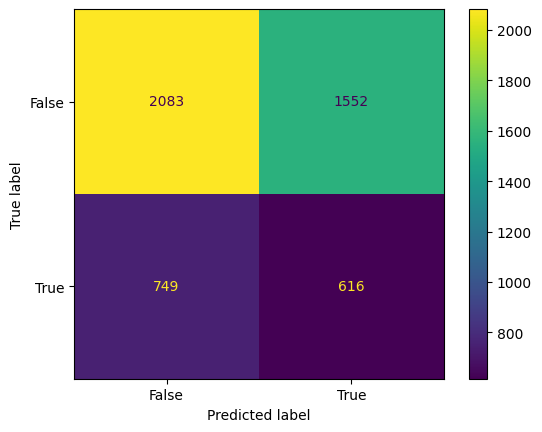

In [ ]:
# calculate percentage
def get_complex_percentage(row, participants_count):
  numerator = 0

  for i in range (participants_count):
    coulmn_name = 'p' + str(i + 1)
    if row[coulmn_name] == 1:
      numerator = numerator + 1

  output = round((numerator / participants_count) * 100, 2)
  return output


df['complex_percentage'] = df.apply(get_complex_percentage, participants_count=5, axis=1)

"""

 	word 	p1 	p2 	p3 	p4 	p5 	majority 	complex_percentage
0 	نژادپرستانه 	1 	0 	1 	0 	0 	0 	40.0
1 	حالشون 	0 	0 	0 	1 	0 	0 	20.0
2 	لرزه‌نگاری 	1 	1 	1 	0 	1 	1 	80.0
3 	لپ 	0 	0 	0 	1 	0 	0 	20.0
4 	تقبیح 	1 	0 	1 	1 	1 	1 	80.0
... 	... 	... 	... 	... 	... 	... 	... 	...
4995 	روزمزد 	0 	0 	1 	0 	0 	0 	20.0
4996 	فرشتگانی 	0 	0 	0 	0 	0 	0 	0.0
4997 	شدهبود 	0 	1 	0 	1 	1 	1 	60.0
4998 	استطلاع 	1 	1 	1 	1 	1 	1 	100.0
4999 	سید 	0 	1 	0 	0 	0 	0 	20.0


"""


adding a sentence containing the lemma. for each lemma.

In [ ]:
word_sents_df = pd.read_csv(word_sents_path)

"""

word 	sentences
0 	سطح 	خصوصیات وینیولا ۲۲ کیلومترمربع مساحت و ۲۵، ۰۸۴...
1 	واقع 	وینیولا به ایتالیایی: یک کومونه در ایتالیا اس...
2 	سن 	اما ابراهیم علیپور، یکی دیگر از پا به سن گذاشت...
3 	بزرگ 	کنوود هاوس یک خانه بزرگ در شمال غربی لندن است...
4 	موزه 	نقاشان صاحب اثر در باغ موزه، یوهانس فرمیر، رام...
... 	... 	...
4995 	پرسید 	وقتی خدا بازگشت، آدم و زن پنهان شدند زیرا می‌د...
4996 	بانگید#بانگ 	آنکه به شکار رفته بود هیاج بن عبدالرحمن ازدی ب...
4997 	خوابید#خواب 	روزنامه‌نگاری که تسلا با او دوست شده بود، تأیی...
4998 	پاگشا 	پاگشا مراسمی است که اقوام عروس و داماد در ایرا...
4999 	اما خرده گیران چپ بر او شوریدند که چرا این فیل... 	اما خرده گیران چپ بر او شوریدند که چرا این فیل...


"""

In [ ]:
def get_ds(sent_df, words, label_df):
  ds = pd.DataFrame()
  for word in words:
    selected_row = sent_df.loc[sent_df['word'] == word ]
    ds = pd.concat([ds, selected_row], ignore_index=True )

  return ds

gold_ds = get_ds(word_sents_df, word_list, words_label_prob_df)
selected_coulmns = words_label_prob_df[['majority', 'complex_percentage']]
gold_ds = gold_ds.join(selected_coulmns)

"""

 	word 	sentences 	majority 	complex_percentage
0 	نژادپرستانه 	مصاحبه فیلم لغو شده اکشن کمدی ساخته کشور آمریک... 	0 	40
1 	حالشون 	خوبه از بچه‌ها بخوام بهم کمک کنند آخه اونا هم ... 	0 	20
2 	لرزه‌نگاری 	پیمان منع جامع آزمایش‌های هسته‌ای در ۲۰ شهریور... 	1 	80
3 	لپ 	مرداب آب بندان لپو زاغمرز در نزدیکی دریای خزر،... 	0 	20
4 	تقبیح 	سید علی غیوری زاده ۱۳۰۹، درگذشت ۲۷ آذر ۱۳۹۳ نم... 	1 	80
... 	... 	... 	... 	...
4991 	روزمزد 	رضا عطارپور مجرد رضا عطارپور مجرد نام مستعار: ... 	0 	20
4992 	فرشتگانی 	براساس احادیث اسلامی، عذاب قبر یا عذاب برزخ سخ... 	0 	0
4993 	شدهبود 	تفریحات لوکس اما رایگان می‌م و پ، یکی از زوجها... 	0 	0
4994 	استطلاع 	فلا تنس هذه النصیح السبت ۱۷ ینایر ۲۰۱۵ ۱۰:۰۷... 	0 	20
4995 	سید 	کمال‌الدین حسین الحسینی معروف به اخلاطی بن علی... 	0 	20


"""

finding end and start index of each word in sentence

In [ ]:
def get_indc(row):
  sent = row['sentences']
  word = row['word']
  indc_list = (0,0)
  if '#' not in word:
    try:
      indc_list = [sent.index(word), sent.index(word)+len(word)-1]
    except:
      print(word)
  else:
    for w in word.split('#'):
      match = re.search(r'\b({})\b'.format(w), sent)
      if match:
        indc_list = (match.start(), match.end())

  return indc_list

coulmns = gold_ds.apply(get_indc, axis = 1, result_type ='expand')
selected_coulmns = coulmns[[0, 1]]
gold_ds = gold_ds.join(selected_coulmns)

gold_ds = gold_ds.rename(columns={0: "str_idx", 1: "end_idx"})

"""

word 	sentences 	majority 	complex_percentage 	str_idx 	end_idx
0 	نژادپرستانه 	مصاحبه فیلم لغو شده اکشن کمدی ساخته کشور آمریک... 	0 	40 	2777 	2787
1 	حالشون 	خوبه از بچه‌ها بخوام بهم کمک کنند آخه اونا هم ... 	0 	20 	46 	51
2 	لرزه‌نگاری 	پیمان منع جامع آزمایش‌های هسته‌ای در ۲۰ شهریور... 	1 	80 	397 	406
3 	لپ 	مرداب آب بندان لپو زاغمرز در نزدیکی دریای خزر،... 	0 	20 	15 	16
4 	تقبیح 	سید علی غیوری زاده ۱۳۰۹، درگذشت ۲۷ آذر ۱۳۹۳ نم... 	1 	80 	3843 	3847
... 	... 	... 	... 	... 	... 	...
4991 	روزمزد 	رضا عطارپور مجرد رضا عطارپور مجرد نام مستعار: ... 	0 	20 	206 	211
4992 	فرشتگانی 	براساس احادیث اسلامی، عذاب قبر یا عذاب برزخ سخ... 	0 	0 	1532 	1539
4993 	شدهبود 	تفریحات لوکس اما رایگان می‌م و پ، یکی از زوجها... 	0 	0 	3365 	3370
4994 	استطلاع 	فلا تنس هذه النصیح السبت ۱۷ ینایر ۲۰۱۵ ۱۰:۰۷... 	0 	20 	183 	189
4995 	سید 	کمال‌الدین حسین الحسینی معروف به اخلاطی بن علی... 	0 	20 	658 	660


"""

# CWI

# Prepare Data: tokenize  phrases (for each word) and label target words: 1 and other 0

In [ ]:
# path to gold_ds dataset created earlier
MAIN_PATH_DATASET = '/content/drive/MyDrive/recourses/ds/modified_ds.csv'
columns = ['target', 'sentence', "binary", "prob", "start", "end"]

def load_df(path):
    df = pd.read_csv(path,)
    df.columns = columns
    return df

dataset = load_df(MAIN_PATH_DATASET)

# extract 50 sentences randomly for furher evaluation using SARI

random_samples= dataset.sample(n=50, random_state=42)
random_samples.to_csv('/content/drive/MyDrive/SARI_samples.csv', index=False)

# dataset:
"""

 	target 	sentence 	binary 	prob 	start 	end
0 	احتراق 	سوخت مایع مولکول‌های قابل احتراق یا تولیدکنند... 	0 	40 	27 	32
1 	نقل 	سوخت‌های مایع در مجموع نقش مهمی در حوزه‌های حم... 	0 	20 	50 	52
2 	بزرگ 	جایزه بزرگ ژاپن یکی از مسابقات قهرمانی جهان فر... 	1 	80 	6 	9
3 	برنامه 	سومین مسابقه قرار بود در آوریل ۱۹۷۸ برگزار شود... 	0 	20 	67 	72
4 	تمام 	این مسابقه با پیروزی ریکاردو پاترسه تمام شد. 	1 	80 	36 	39
... 	... 	... 	... 	... 	... 	...
4995 	کانی‌شناس 	فرانتسیوزف مولر فون رایشنشتین، زاده ۱ ژوئیه ۱۷... 	0 	20 	96 	104
4996 	سنگ‌شناس 	همه گوته آلمانی را بیش‌تر به‌عنوان شاعر می‌شنا... 	0 	0 	69 	76
4997 	خواهیدآورد 	اگر توانایی انجام خدماتی را برای سایر کسب و کا... 	1 	60 	351 	360
4998 	مونوکلینیک 	سیلیکات با از مجموعه کانی هاست و سفید محلول در... 	1 	100 	267 	276
4999 	راه‌نما 	علم مواد معمولا ویژگی‌های شیمیایی یک ماده را ب... 	0 	20 	57 	63



"""

tokenizer = WordTokenizer()

def get_max_len(row):
  seq = row['sentence']
  output = len(tokenizer.tokenize(seq))
  print(tokenizer.tokenize(seq))
  return output

dataset['seq_length'] = dataset.apply(get_max_len, axis=1)
dataset['seq_length'].max()

normalizer = Normalizer()
tokenizer = WordTokenizer(join_verb_parts=False)

#  identifying and categorizing punctuation characters. as tbl for a dictionary
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

def all_tokens_with_index(context):
  """
  return tokens of context + its index (in context) + token current position in context
  """
  targets = []
  # normalize, no repetetive white space
  context = normalizer.normalize(context)
  context = normalizer.correct_spacing(context)
  # tokenize
  tokens = tokenizer.tokenize(context)
  for index, token in enumerate(tokens, 1):
    match = re.search(r'\b({})\b'.format(re.escape(token)), context)

    if match != None:
      curr_pos = match.start()
      end_pos = match.end()
    else:
      curr_pos = context.index(token)
      end_pos = context.index(token) + len(token)

    targets.append((token, index, curr_pos, end_pos))

  return [val for val in targets if val[0] != '"']

  def forward_transformation(dataframe, filter_punc = True,):
  """
  input: dataframe
  process: preprocess context: , remove_punct, tokenize and index using prior function
  output: a list of a  dictionary. key: sentence, seq. value:'sent', [(prob, bibnary, end, start, token),...,()], list name is sentences
  ***** consider that this methode is making a list of unique sentences so the length might be differnt but if n sentences were same it would merge and as tag bring n target words, like this: 'tags': [('بدهکار', 19729, 19734, 1, 80), ('برآمده', 5698, 5703, 0, 40)]

  """
  grouped = dataframe.groupby('sentence').apply(lambda row :
                      {
                        'sentence' : list(set(row['sentence']))[0],
                        'tags': [tag for tag in zip(row['target'],
                          row['start'], row['end'], row['binary'], row['prob'])]})
  sentences = []
  for vals in grouped:
      sentence = vals['sentence']
      tags = vals['tags']
      tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
      all_tokens = all_tokens_with_index(sentence)

      sent_repr = []
      for word, index, start, end in all_tokens:

          for (w, s, e) in tags_without_labels:
            if word == w:
              sent_repr.append((
                  w, s, e,
                  tags[tags_without_labels.index((w, s, e))][3],
                  tags[tags_without_labels.index((w, s, e))][4]
              ))
            else:
              sent_repr.append((word, start, end, 0, 0.0))

      if filter_punc:
          sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))

      sentences.append({'sentence' : sentence, 'seq' : sent_repr})
  return sentences

def split_sentence_seqs(sentences):
  words, start_end, binary, prob = [], [], [] ,[]
  for sent in sentences:
      sequence = sent['seq']
      curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0],
          (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
      words.append(curr_w)
      start_end.append(curr_se)
      binary.append(curr_b)
      prob.append(curr_p)
  return words, start_end, binary, prob

sentences = forward_transformation(dataset)


words, start_end, binary, prob = split_sentence_seqs(sentences)

def get_data_dic(words, start_end, binary, prob):
  train_dic = {}
  id_list = []

  for i in range(0, len(words)):
    id_list.append(i)

  train_dic['id'] = id_list
  train_dic['tokens'] = words
  train_dic['start_end'] = start_end
  train_dic['label'] = binary
  train_dic['complex_prob'] = prob

  return train_dic


dataset_dict = get_data_dic(words, start_end, binary, prob)

from datasets import Dataset
ds = Dataset.from_dict(dataset_dict)
ds

"""
Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob'],
    num_rows: 4974
})

"""

from datasets import DatasetDict
# 90% train, 10% test + validation
train_testvalid = ds.train_test_split(test_size=0.1)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

train_test_valid_dataset


"""


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'start_end', 'label', 'complex_prob'],
        num_rows: 4476
    })
    test: Dataset({
        features: ['id', 'tokens', 'start_end', 'label', 'complex_prob'],
        num_rows: 249
    })
    valid: Dataset({
        features: ['id', 'tokens', 'start_end', 'label', 'complex_prob'],
        num_rows: 249
    })
})

longest length of a sequence in sentence coulmn is 219 tokens, and shortest length is 3 tokens

"""


#prepare data2: tokenization using ParsBERT Also aligning labels with subwords

In [ ]:
trial_tokenizer =  AutoTokenizer.from_pretrained('HooshvareLab/bert-base-parsbert-armanner-uncased')
trial_model = AutoModelForTokenClassification.from_pretrained('HooshvareLab/bert-base-parsbert-armanner-uncased')

def tokenize_and_align_labels(examples):
    max_length = 219
    tokenized_inputs = trial_tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, padding= 'max_length', max_length=max_length,
                                   add_special_tokens=True # Add special tokens CLS and SEP)
    )

    L_dic ={}
    # P_dic = {}
    # start_end_dic = {}

    label_ids = []
    # prob_ids = []
    # start_end_ids = []

    for i, label in enumerate(examples['label']):   #batch_data['label']
        word_ids = tokenized_inputs.word_ids()  # Map tokens to their respective word.
        previous_word_idx = None
        L_dic[i] = label    #key is word_index and value is label of that word_index

    # for i, prob in enumerate(example['complex_prob']):
    #     P_dic[i] = prob    #key is word_index and value is label of that word_index

    # for i, s_e_idx in enumerate(example['start_end']):
    #     start_end_dic[i] = s_e_idx    #key is word_index and value is label of that word_index


    for word_idx in word_ids:  # Set the special tokens to -100.

        if word_idx is None:
            label_ids.append(-100)
            # prob_ids.append(-100)
            # start_end_ids.append(-100)

        elif word_idx != previous_word_idx:  # Only label the first token of a given word.
            label_ids.append(L_dic[word_idx])
            # prob_ids.append(P_dic[word_idx])
            # start_end_ids.append(start_end_dic[word_idx])
        else:
            label_ids.append(-100)
            # prob_ids.append(-100)
            # start_end_ids.append(-100)

        previous_word_idx = word_idx

    tokenized_inputs["aligned_labels"] = label_ids
    # tokenized_inputs["c_prob"] = prob_ids
    # tokenized_inputs["s_e_idx"] = start_end_ids

    return tokenized_inputs

tokenized_data_train = train_test_valid_dataset['train'].map(tokenize_and_align_labels,)
tokenized_data_test = train_test_valid_dataset['test'].map(tokenize_and_align_labels,)
tokenized_data_val = train_test_valid_dataset['valid'].map(tokenize_and_align_labels,)

tensor_train_dataset = tokenized_data_train.with_format("torch")
tensor_test_dataset = tokenized_data_test.with_format("torch")
tensor_val_dataset = tokenized_data_val.with_format("torch")

tensor_dataset = concatenate_datasets([tensor_train_dataset, tensor_test_dataset, tensor_test_dataset])

"""


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'aligned_labels'],
        num_rows: 4476
    })
    test: Dataset({
        features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'aligned_labels'],
        num_rows: 249
    })
    valid: Dataset({
        features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'aligned_labels'],
        num_rows: 249
    })
})



"""



In [ ]:
# # save tokenized dataset in torch tensor style in save_path:
save_path = '/content/drive/MyDrive/recourses/ds'
tokenized_data.save_to_disk(save_path)

In [ ]:
# load presaved_tokenized + embeddings dataset in tensor format

ds_train = load_from_disk("/content/drive/MyDrive/with_embds_1/train")
ds_test = load_from_disk("/content/drive/MyDrive/with_embds_1/test")
ds_val = load_from_disk("/content/drive/MyDrive/with_embds_1/valid")


"""

Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'aligned_labels', 'embedding'],
    num_rows: 4476
})
Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'aligned_labels', 'embedding'],
    num_rows: 249
})
Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'aligned_labels', 'embedding'],
    num_rows: 249
})


"""

# extract embeddings

A. in get_emb_ver4 we extract embeddings for all words in input sequence. this embedding is going to use in my implementation for complex word identification, using MLP and BiLSTM networks.

In [ ]:
def get_emb_ver4(ds):
    trial_model.eval()

    with torch.no_grad():
        hidden_states = trial_model(ds['input_ids'].unsqueeze(0), ds['attention_mask'].unsqueeze(0), output_hidden_states=True)['hidden_states']

    token_embeddings = torch.stack(hidden_states[-4:], dim=0).squeeze(1).permute(1, 0, 2)
    token_vecs_sum = torch.stack([torch.sum(token[-4:], dim=0) for token in token_embeddings])


    return {'embedding': token_vecs_sum}

train_ds_embd = tensor_train_dataset.map(get_emb_ver4)
test_ds_emb = tensor_test_dataset.map(get_emb_ver4)
val_ds_emb = tensor_val_dataset.map(get_emb_ver4)

# save embeddings

path = '/content/drive/MyDrive/pars_bert_withemb'
train_path = path + '/train'
test_path = path + '/test'
val_path = path + '/val'

train_ds_embd.save_to_disk(train_path)
test_ds_emb.save_to_disk(test_path)
val_ds_emb.save_to_disk(val_path)

# retain it
ds_train = load_from_disk("/content/drive/MyDrive/pars_bert_withemb/train")
ds_test = load_from_disk("/content/drive/MyDrive/pars_bert_withemb/test")
ds_val = load_from_disk("/content/drive/MyDrive/pars_bert_withemb/val")

"""

Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'token_type_ids', 'attention_mask', 'aligned_labels', 'embedding'],
    num_rows: 4476
})
Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'token_type_ids', 'attention_mask', 'aligned_labels', 'embedding'],
    num_rows: 249
})
Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'token_type_ids', 'attention_mask', 'aligned_labels', 'embedding'],
    num_rows: 249
})

"""

B. in get_emb_ver4 we extract embeddings for only target words (the 5k words that were extracted initialy). this is done by extracting embeding for each word in a sequence and then extracting only the target word embedding.

this is going to use in complex word identification models base on SVM and Balance Random Forest.


In [ ]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

def get_target_idx(tokens_list, target_word, ):
  target_idx = -1
  try:
    if '#' in target_word:
      target_word_list = target_word.split('#')
      for word in target_word_list:
        if word in tokens_list:
          target_idx = tokens_list.index(word)
    else:
      target_idx = tokens_list.index(target_word)
  except:
    print(target_word)
  return target_idx

def get_word_embedding(ds, tokenizer=R_tokenizer, model=R_model):

  text = ds['sentences']
  target_word = ds['tokens']
  text = remove_punctuation(text=text)
  tokens_list = text.split()

  encoded = R_tokenizer(text, return_tensors="pt").to(device)

  target_idx = get_target_idx(tokens_list, target_word)

  token_ids_word = np.where(np.array(encoded.word_ids()) == target_idx)
  model.eval()

  with torch.no_grad():
      hidden_states =  model(encoded['input_ids'], encoded['attention_mask'], output_hidden_states=True)['hidden_states']

  token_embeddings = torch.stack(hidden_states[-4:], dim=0).squeeze(1).permute(1, 0, 2)
  token_vecs_sum = torch.stack([torch.sum(token[-4:], dim=0) for token in token_embeddings])

  word_tokens_output = token_vecs_sum[token_ids_word]


  return {'embedding': word_tokens_output.mean(dim=0)}

# retrive data and Final Prepration!

retrive dtast

In [ ]:
ds_train = load_from_disk("/content/drive/MyDrive/pars_bert_withemb/train")
ds_test = load_from_disk("/content/drive/MyDrive/pars_bert_withemb/test")
ds_val = load_from_disk("/content/drive/MyDrive/pars_bert_withemb/val")

In [ ]:
train_dataset = ds_train.remove_columns(['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'token_type_ids'])
test_dataset = ds_test.remove_columns(['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'token_type_ids'])
val_dataset = ds_val.remove_columns(['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'token_type_ids'])

**weights**

In [ ]:
labels = train_dataset['aligned_labels']
mask = (labels != -100)
masked_labels = labels[mask]

classes = np.unique(masked_labels)
print(classes)
weights = compute_class_weight(class_weight="balanced", classes= classes, y= masked_labels.numpy())
# weights:
"""[0 1]

array([ 0.50350712, 71.7834891 ])"""

weights = torch.tensor([ 0.50350712, 71.7834891 ])

device, plot function and time function

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



# LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import spacy
import numpy as np

import time
import random

import torch.nn.functional as F

from sklearn.metrics import precision_score, recall_score, f1_score

# from torchmetrics.classification import BinaryAccuracy

In [ ]:
class BiLSTMTagger(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout,
                        ):

        super(BiLSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0,
                            batch_first =True,)

        # self.batch_norm = nn.BatchNorm1d(2 * hidden_dim)

        # self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def forward(self, embedded_text):

        outputs, _ = self.lstm(embedded_text)

        # outputs = self.batch_norm(outputs.permute(0, 2, 1))

        # logits = self.dropout(self.fc(self.dropout(outputs.permute(0, 2, 1))))
        logits = self.dropout(self.fc(self.dropout(outputs)))

        return logits

In [ ]:
INPUT_DIM = 768
HIDDEN_DIM = 32
OUTPUT_DIM = 2
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.6

bilstm_model = BiLSTMTagger(INPUT_DIM,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT,
                        )

criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=weights)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.NAdam(bilstm_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min')


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

bilstm_model.apply(init_weights)

BiLSTMTagger(
  (lstm): LSTM(768, 32, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)

In [ ]:
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall

acc_metric = MulticlassAccuracy(num_classes=2, ignore_index=-100)
F1_metric = MulticlassF1Score(num_classes=2, ignore_index=-100)
percision_metric = MulticlassPrecision(num_classes=2, ignore_index=-100)
recall_metric = MulticlassF1Score(num_classes=2, ignore_index=-100)


In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0

    model.train()

    for batch in iterator:

        embeds = batch['embedding'].to(device)
        tags = batch['aligned_labels'].to(device)

        optimizer.zero_grad()


        predictions = model(embeds)

        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        loss = criterion(predictions, tags)



        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()


    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):

    epoch_loss = 0

    acc = 0.0
    F1 = 0.0
    recall = 0.0
    perc = 0.0

    i = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:
            i = i + 1
            embds = batch['embedding'].to(device)
            tags = batch['aligned_labels'].to(device)

            outputs = model(embds)

            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)


            loss = criterion(outputs, tags)

            epoch_loss += loss.item()

            # calculate metrics using ignit
            acc += acc_metric(outputs, tags)
            F1 += F1_metric(outputs, tags)
            perc += percision_metric(outputs, tags)
            recall += recall_metric(outputs, tags)





    precision = perc/i
    recall = recall/i
    F1 = F1/i
    accuracy = acc/i

    g1 = (2*(accuracy * recall)) / (accuracy + recall)



    print('\n -----------------------------')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {F1:.4f}")
    print(f"accuracy: {accuracy:.4f}")
    print(f"G1 Score: {g1:.4f}")



    avr_test_loss = epoch_loss / len(iterator)



    return avr_test_loss




In [ ]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=30, shuffle=True, num_workers=2)
valid_iterator = torch.utils.data.DataLoader(val_dataset, batch_size=30, shuffle=True, num_workers=2)

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')


    scheduler.step(valid_loss)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Loss: ', train_loss)
    train_losses.append(train_loss)
    print('Val. Loss: ', valid_loss)
    val_losses.append(valid_loss)

# Val. Acc: {valid_acc*100:.2f}
#  Train Acc: {train_acc*100:.2f}

In [ ]:
# save model
print(train_losses, '\n', val_losses)
plot_loss_curve(train_losses, val_losses)
torch.save(model, '/content/drive/MyDrive/bilstm_2.pth')





```
Precision: 0.5199
Recall: 0.5101
F1 Score: 0.5101
accuracy: 0.8024
G1 Score: 0.6237
Epoch: 01 | Epoch Time: 5m 33s
Train Loss:  0.4470985011259715
Val. Loss:  0.3810286687480079
—------------------------------
Precision: 0.5115
Recall: 0.4627
F1 Score: 0.4627
accuracy: 0.7969
G1 Score: 0.5855
Epoch: 02 | Epoch Time: 5m 7s
Train Loss:  0.4373612477382024
Val. Loss:  0.39831074078877765
—------------------------------
Precision: 0.5190
Recall: 0.4997
F1 Score: 0.4997
accuracy: 0.8457
G1 Score: 0.6282
Epoch: 03 | Epoch Time: 5m 29s
Train Loss:  0.42501645763715107
Val. Loss:  0.3604854775799645
—------------------------------
Precision: 0.5223
Recall: 0.5158
F1 Score: 0.5158
accuracy: 0.8185
G1 Score: 0.6328
Epoch: 04 | Epoch Time: 5m 24s
Train Loss:  0.4198496466875076
Val. Loss:  0.3671598931153615
—------------------------------
Precision: 0.5233
Recall: 0.5184
F1 Score: 0.5184
accuracy: 0.8073
G1 Score: 0.6313
Epoch: 05 | Epoch Time: 5m 35s
Train Loss:  0.4186057557662328
Val. Loss:  0.41698815259668565
—------------------------------
Precision: 0.5242
Recall: 0.5245
F1 Score: 0.5245
accuracy: 0.7658
G1 Score: 0.6226
Epoch: 06 | Epoch Time: 5m 22s
Train Loss:  0.41700501372416815
Val. Loss:  0.4227830618619919
—------------------------------
Precision: 0.5197
Recall: 0.5070
F1 Score: 0.5070
accuracy: 0.8024
G1 Score: 0.6213
Epoch: 07 | Epoch Time: 5m 36s
Train Loss:  0.3977813877662023
Val. Loss:  0.39078015089035034
—------------------------------
Precision: 0.5212
Recall: 0.5196
F1 Score: 0.5196
accuracy: 0.7694
G1 Score: 0.6203
Epoch: 08 | Epoch Time: 5m 29s
Train Loss:  0.39468146314223607
Val. Loss:  0.46729664338959587
—------------------------------
Precision: 0.5202
Recall: 0.5138
F1 Score: 0.5138
accuracy: 0.7715
G1 Score: 0.6168
Epoch: 09 | Epoch Time: 5m 58s
Train Loss:  0.3985196859637896
Val. Loss:  0.38831304841571385
—------------------------------
Precision: 0.5219
Recall: 0.5207
F1 Score: 0.5207
accuracy: 0.7836
G1 Score: 0.6256
Epoch: 10 | Epoch Time: 5m 51s
Train Loss:  0.3918690818548203
Val. Loss:  0.4304463068644206
—------------------------------
Precision: 0.5255
Recall: 0.5274
F1 Score: 0.5274
accuracy: 0.7614
G1 Score: 0.6231
Epoch: 11 | Epoch Time: 5m 44s
Train Loss:  0.3821021800239881
Val. Loss:  0.4549918870131175
—------------------------------
Precision: 0.5194
Recall: 0.5112
F1 Score: 0.5112
accuracy: 0.7672
G1 Score: 0.6136
Epoch: 12 | Epoch Time: 5m 44s
Train Loss:  0.38520427107810973
Val. Loss:  0.39930057856771684
—------------------------------
Precision: 0.5246
Recall: 0.5269
F1 Score: 0.5269
accuracy: 0.7892
G1 Score: 0.6319
Epoch: 13 | Epoch Time: 5m 44s
Train Loss:  0.3744424530863762
Val. Loss:  0.40717992848820156
—------------------------------
Precision: 0.5216
Recall: 0.5202
F1 Score: 0.5202
accuracy: 0.7574
G1 Score: 0.6168
Epoch: 14 | Epoch Time: 6m 23s
Train Loss:  0.37917419930299123
Val. Loss:  0.4537353151374393
—------------------------------
Precision: 0.5235
Recall: 0.5238
F1 Score: 0.5238
accuracy: 0.7715
G1 Score: 0.6240
Epoch: 15 | Epoch Time: 6m 12s
Train Loss:  0.3687762004137039
Val. Loss:  0.47608043087853325
—------------------------------
Precision: 0.5232
Recall: 0.5226
F1 Score: 0.5226
accuracy: 0.7764
G1 Score: 0.6247
Epoch: 16 | Epoch Time: 6m 24s
Train Loss:  0.35695472369591397
Val. Loss:  0.44623111022843254
—------------------------------
Precision: 0.5237
Recall: 0.5259
F1 Score: 0.5259
accuracy: 0.7487
G1 Score: 0.6178
Epoch: 17 | Epoch Time: 6m 25s
Train Loss:  0.35455466926097867
Val. Loss:  0.5084982216358185
—------------------------------
Precision: 0.5204
Recall: 0.5193
F1 Score: 0.5193
accuracy: 0.7063
G1 Score: 0.5985
Epoch: 18 | Epoch Time: 6m 16s
Train Loss:  0.351669171055158
Val. Loss:  0.477103806204266
—------------------------------
Precision: 0.5278
Recall: 0.5345
F1 Score: 0.5345
accuracy: 0.7599
G1 Score: 0.6275
Epoch: 19 | Epoch Time: 6m 21s
Train Loss:  0.3559552330772082
Val. Loss:  0.4670061121384303
—------------------------------
Precision: 0.5225
Recall: 0.5232
F1 Score: 0.5232
accuracy: 0.7229
G1 Score: 0.6071
Epoch: 20 | Epoch Time: 6m 10s
Train Loss:  0.350294684668382
Val. Loss:  0.4824233320024278



```





---



---



---



# MLP

In [ ]:
# Define PyTorch model, with dropout at input
class TokenClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(TokenClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.7)

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            # nn.BatchNorm1d(hidden_size1, momentum=0.9),
            nn.LeakyReLU(),
            # self.dropout,

            nn.Linear(hidden_size1, hidden_size2),
            # nn.BatchNorm1d(hidden_size2, momentum=0.9),
            nn.LeakyReLU(),
            # self.dropout,

            nn.Linear(hidden_size2, hidden_size3),
            # # nn.BatchNorm1d(hidden_size3, momentum=0.9),
            nn.LeakyReLU(),
            self.dropout,

            nn.Linear(hidden_size3, output_size)
        )


    def forward(self, x):

        # x = self.flatten(x)
        # print(x.shape)
        x = self.layers(x)

        return x

# He weight initalizer
@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight,)

input_size = 768  # Total number of features in the flattened input
hidden_size1 = 32
hidden_size2 = 16
hidden_size3 = 16
output_size = 2


mlp_model = TokenClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, output_size).to(device)
mlp_model.apply(init_weights)
print(mlp_model)

TokenClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.7, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.7, inplace=False)
    (7): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [ ]:
# Define model and parameters


learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss(ignore_index=-100, weight=weights)
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min')

n_epochs = 15




In [ ]:

def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset) #4476
  model.train()
  total_loss = 0.0

  for i, batch in enumerate(dataloader, 0):
      inputs = batch['embedding'].to(device)
      labels = batch['aligned_labels'].to(device)


      # Compute prediction and loss
      logits = model(inputs)

      logits = logits.view(-1, logits.shape[-1])
      labels = labels.view(-1)

      loss =  loss_fn(logits, labels)

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      total_loss += loss.item()


      if i % 100 == 0:
            loss, current = loss.item(), (i + 1) * len(inputs)
            print(f"train_loss: {round(loss, 4):>7f}  [{current:>5d}/{size:>5d}]")

  return total_loss / len(dataloader)


def test_loop(dataloader, model, loss_fn):
    model.eval()

    size = len(dataloader.dataset) #249 = total number of validation samples
    num_batches = len(dataloader)   #9

    test_loss = 0.0
    # correct =  0

    # all_predictions = []
    # all_labels = []
    acc = 0.0
    F1 = 0.0
    recall = 0.0
    perc = 0.0


    with torch.no_grad():

      for i, batch in enumerate(dataloader, 0):
          inputs = batch['embedding'].to(device)
          labels = batch['aligned_labels'].to(device)

          # outputs = model(inputs)
          logits = model(inputs)

          logits = logits.view(-1, logits.shape[-1])
          labels = labels.view(-1)

          loss =  loss_fn(logits, labels)

          test_loss += loss.item()

          if i % 100 == 0:
            loss, current = loss.item(), (i + 1) * len(inputs)
            print(f"test_loss: {round(loss, 4):>7f}  [{current:>5d}/{size:>5d}]")

          # calculate metrics using ignit
          acc += acc_metric(logits, labels)
          F1 += F1_metric(logits, labels)
          perc += percision_metric(logits, labels)
          recall += recall_metric(logits, labels)



    precision = perc/num_batches
    recall = recall/num_batches
    F1 = F1/num_batches
    accuracy = acc/num_batches
    g1 = (2*(accuracy * recall)) / (accuracy + recall)


    # Print or log the evaluation metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {F1:.4f}")
    print(f"accuracy: {accuracy:.4f}")
    print(f"G1 Score: {g1:.4f}")
    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1 Score: {f1:.4f}")

    # correct /= size
    avr_test_loss = test_loss / len(dataloader)

    print(f"Avg test_loss: {avr_test_loss:>8f} \n")



    return avr_test_loss

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
  if 'weight' in name:
        print(f'Layer: {name} | Mean: {param.mean().item()} | Std: {param.std().item()} | Values : {param[:2]} \n')



Model structure: TokenClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.7, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.7, inplace=False)
    (7): Linear(in_features=16, out_features=2, bias=True)
  )
)


Layer: layers.0.weight | Mean: 0.00029602154972963035 | Std: 0.050884976983070374 | Values : tensor([[ 0.0172,  0.0550,  0.0427,  ..., -0.0675,  0.0443, -0.0534],
        [-0.0663, -0.0397,  0.0605,  ..., -0.0182,  0.0466, -0.0829]],
       grad_fn=<SliceBackward0>) 

Layer: layers.2.weight | Mean: -0.01516300905495882 | Std: 0.2435980588197708 | Values : tensor([[ 0.3902,  0.0089,  0.1782, -0.3817, -0.0205, -0.2448, -0.3407,  0.3579,
       

In [ ]:

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses


for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    train_loss = train_loop(trainloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    val_loss = test_loop(validationloader, model, loss_fn)
    val_losses.append(val_loss)

    scheduler.step(val_loss)


print("Done!")

Epoch 1
-------------------------------
train_loss: 0.563700  [   30/ 4476]
train_loss: 0.518400  [ 3030/ 4476]
test_loss: 0.610800  [   30/  249]
Precision: 0.5096
Recall: 0.4321
F1 Score: 0.4321
accuracy: 0.8055
G1 Score: 0.5625
Avg test_loss: 0.480997 

Epoch 2
-------------------------------
train_loss: 0.588900  [   30/ 4476]
train_loss: 0.801100  [ 3030/ 4476]
test_loss: 0.330000  [   30/  249]
Precision: 0.5122
Recall: 0.4589
F1 Score: 0.4589
accuracy: 0.8405
G1 Score: 0.5937
Avg test_loss: 0.369417 

Epoch 3
-------------------------------
train_loss: 0.464400  [   30/ 4476]
train_loss: 0.360600  [ 3030/ 4476]
test_loss: 0.291100  [   30/  249]
Precision: 0.5122
Recall: 0.4601
F1 Score: 0.4601
accuracy: 0.8477
G1 Score: 0.5964
Avg test_loss: 0.358399 

Epoch 4
-------------------------------
train_loss: 0.387100  [   30/ 4476]
train_loss: 0.378900  [ 3030/ 4476]
test_loss: 0.270300  [   30/  249]
Precision: 0.5119
Recall: 0.4579
F1 Score: 0.4579
accuracy: 0.8199
G1 Score: 0.587

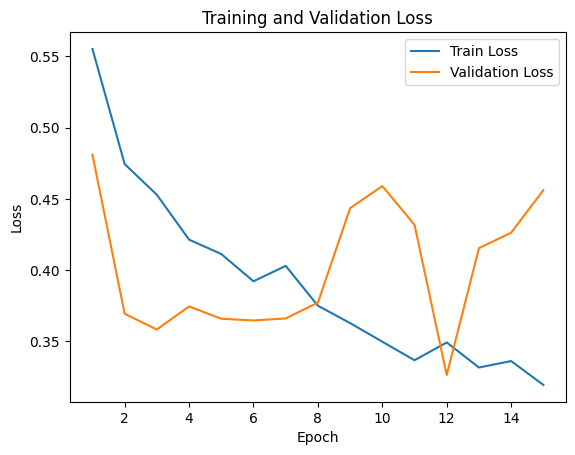

In [ ]:
plot_loss_curve(train_losses, val_losses)


In [ ]:
output = torch.randn(30, 219, 2)
labels = torch.randn(30, 219)

output = output.view(-1, output.shape[-1])
labels = labels.view(-1)
print(output.shape, labels.shape)

torch.Size([6570, 2]) torch.Size([6570])


In [ ]:
torch.save(model, '/content/drive/MyDrive/modified_MLP_cwi.pth')

# Balance Random Forest and SVM

prepare data

In [ ]:
X = ds_train['embedding']
y = ds_train['labels']

In [ ]:
X_test = ds_test['embedding']
y_test = ds_test['labels']

In [ ]:
from sklearn import svm
import numpy as np
from sklearn.impute import SimpleImputer
# handling Nan in X
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X)

X_train_imp = imp.transform(X)
X_test_imp = imp.transform(X_test)

# clf = svm.SVC()
# clf = clf.fit(X_train_imp, y)
# predictions = clf.predict(X_test_imp)


SVM

In [ ]:
svm_clf = Pipeline([
("scaler", StandardScaler()),
("linear_svc", LinearSVC(C=1, loss="hinge", class_weight='balanced')),
])
svm_clf.fit(X_train_imp, y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, class_weight='balanced', loss='hinge'))])

Confusion Matrix:
[[138  42]
 [ 45  25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       180
           1       0.37      0.36      0.36        70

    accuracy                           0.65       250
   macro avg       0.56      0.56      0.56       250
weighted avg       0.65      0.65      0.65       250



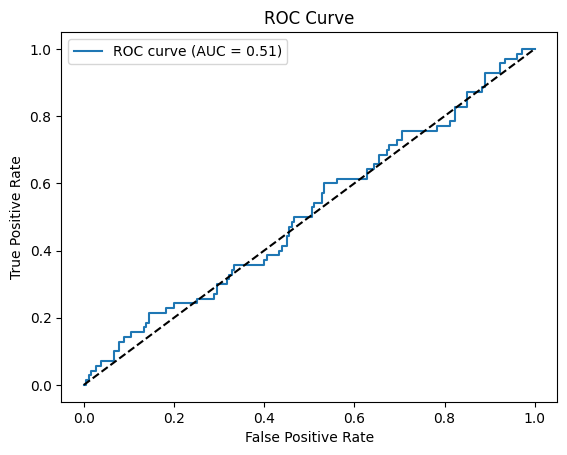

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC curve and AUC score
y_scores = svm_clf.decision_function(X_test_imp)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


BRF

In [ ]:
!pip install -U imbalanced-learn


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report

# Assuming X_train_imp, y_train are your training data
# and X_test_imp, y_test are your test data

# Define the BalancedRandomForestClassifier
brf_clf = BalancedRandomForestClassifier(n_estimators=100, random_state=4, class_weight='balanced')

# Fit the model
brf_clf.fit(X_train_imp, y)

# Make predictions
y_pred = brf_clf.predict(X_test_imp)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       180
           1       0.37      0.36      0.36        70

    accuracy                           0.65       250
   macro avg       0.56      0.56      0.56       250
weighted avg       0.65      0.65      0.65       250



# complex word identification model by finetunning parsbert


**prepare data phase 2 (prepare data for transformers, tokenize and allign labels)**

In [ ]:
model_checkpoint = 'FacebookAI/xlm-roberta-large-finetuned-conll03-english'
roberta_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# def tokenize_and_align_labels(token, label, model_tokenizer=trial_tokenizer): #batch_data
def tokenize_and_align_labels(examples):
    max_length = 219
    tokenized_inputs = roberta_tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, padding= 'max_length', max_length=max_length,
                                   add_special_tokens=True # Add special tokens CLS and SEP)
    )

    L_dic ={}
    # P_dic = {}
    # start_end_dic = {}

    label_ids = []
    # prob_ids = []
    # start_end_ids = []

    for i, label in enumerate(examples['label']):   #batch_data['label']
        word_ids = tokenized_inputs.word_ids()  # Map tokens to their respective word.
        previous_word_idx = None
        L_dic[i] = label    #key is word_index and value is label of that word_index

    # for i, prob in enumerate(example['complex_prob']):
    #     P_dic[i] = prob    #key is word_index and value is label of that word_index

    # for i, s_e_idx in enumerate(example['start_end']):
    #     start_end_dic[i] = s_e_idx    #key is word_index and value is label of that word_index


    for word_idx in word_ids:  # Set the special tokens to -100.

        if word_idx is None:
            label_ids.append(-100)
            # prob_ids.append(-100)
            # start_end_ids.append(-100)

        elif word_idx != previous_word_idx:  # Only label the first token of a given word.
            label_ids.append(L_dic[word_idx])
            # prob_ids.append(P_dic[word_idx])
            # start_end_ids.append(start_end_dic[word_idx])
        else:
            label_ids.append(-100)
            # prob_ids.append(-100)
            # start_end_ids.append(-100)

        previous_word_idx = word_idx

    tokenized_inputs["aligned_labels"] = label_ids
    # tokenized_inputs["c_prob"] = prob_ids
    # tokenized_inputs["s_e_idx"] = start_end_ids

    return tokenized_inputs

In [ ]:
tokenized_data_train = train_test_valid_dataset['train'].map(tokenize_and_align_labels,)


In [ ]:
tokenized_data_test = train_test_valid_dataset['test'].map(tokenize_and_align_labels,)


In [ ]:
tokenized_data_val = train_test_valid_dataset['valid'].map(tokenize_and_align_labels,)

In [ ]:
tokenized_data_train

Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'aligned_labels'],
    num_rows: 4476
})

In [ ]:
# working with parsbert
tensor_train_dataset = tokenized_data_train.with_format("torch")
tensor_test_dataset = tokenized_data_test.with_format("torch")
tensor_val_dataset = tokenized_data_val.with_format("torch")

In [ ]:
from datasets import Dataset, DatasetDict, concatenate_datasets

In [ ]:
concatenated_dataset = concatenate_datasets([tensor_train_dataset, tensor_test_dataset, tensor_test_dataset])
# concatenated_dataset

In [ ]:
concatenated_dataset

Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'attention_mask', 'aligned_labels'],
    num_rows: 4974
})

**save and retain dataset**

In [ ]:
bert_path = '/content/drive/MyDrive/bert_tokenized_data'
roberta_path = '/content/drive/MyDrive/roberta_tokenized_data'


In [ ]:
# load presaved_tokenized + embeddings dataset in tensor format

ds_train = load_from_disk(bert_path + '/train')
ds_test = load_from_disk(bert_path+ '/test' )
ds_val = load_from_disk(bert_path + '/val')

In [ ]:
ds_train

Dataset({
    features: ['id', 'tokens', 'start_end', 'label', 'complex_prob', 'input_ids', 'token_type_ids', 'attention_mask', 'aligned_labels'],
    num_rows: 4476
})

In [ ]:
# rename and remove ds
ds_train = ds_train.remove_columns("label")
ds_train = ds_train.rename_column("aligned_labels", "labels")

ds_test = ds_test.remove_columns("label")
ds_test = ds_test.rename_column("aligned_labels", "labels")

In [ ]:
ds_train2 = ds_train.remove_columns(['id', 'tokens', 'start_end','complex_prob'])


In [ ]:
ds_test2 = ds_test.remove_columns(['id', 'tokens', 'start_end','complex_prob'])
ds_test2

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 249
})

In [ ]:
# calculate class weight
from sklearn.utils.class_weight import compute_class_weight

labels = ds_train2['labels']
mask = (labels != -100)
masked_labels = labels[mask]

classes = np.unique(masked_labels)
print(classes)
weights = compute_class_weight(class_weight="balanced", classes= classes, y= masked_labels.numpy())
weights

[0 1]


array([ 0.50352224, 71.47746698])

In [ ]:
model_checkpoint_R = 'FacebookAI/xlm-roberta-large-finetuned-conll03-english'
model_checkpoint_B = 'HooshvareLab/bert-base-parsbert-ner-uncased'
llm_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_B)

**finetune**

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=llm_tokenizer)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    ds_train2,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=30,
)
eval_dataloader = DataLoader(
    ds_test2, collate_fn=data_collator, batch_size=8
)

In [ ]:
id2label={0: 'non_complex', 1: 'complex'}

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint_B,
    num_labels=2,
    ignore_mismatched_sizes=True,
    id2label=id2label
)


In [ ]:
from torch.optim import AdamW
from torch import nn

optimizer = AdamW(model.parameters(), lr=2e-5)

# loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.68721065, 1.83539413]).to(device))


In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
print(num_update_steps_per_epoch)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = 'cwi_bert_base_ver2'
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
output_dir = "/content/Untitled Folder"
repo = Repository(output_dir, clone_from=repo_name)
repo

**Training** **loop**

In [ ]:
import evaluate

clf_metrics = evaluate.combine(["precision", "recall"])
accuracy_metric = evaluate.load("accuracy")

f1_metric = evaluate.load("f1")


In [ ]:
def postprocess(predictions, labels):

    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels

    true_predictions = [
    [p for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
    true_labels = [
        [l for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return true_labels, true_predictions

In [ ]:
weights = torch.tensor([ 0.50352224, 71.47746698])


In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))
avr_train_loss = []
avr_test_loss = []

for epoch in range(num_train_epochs):
    train_epoch_loss = 0
    test_epoch_loss = 0

    # Training
    model.train()

    for batch in train_dataloader:

        labels = batch['labels']

        outputs = model(**batch)

        logits = outputs.logits
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(ignore_index=-100, weight=weights.to(device))

        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        # loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_epoch_loss += loss.item()
        progress_bar.update(1)

    avr_train_loss.append(train_epoch_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # calculate test loss
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(ignore_index=-100, weight=weights.to(device))

        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        test_epoch_loss += loss.item()
        # test_epoch_loss  += outputs.loss.item()
        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)

        for refs, preds in zip( true_labels , true_predictions):

          clf_metrics.add_batch(predictions=preds, references=refs)
          accuracy_metric.add_batch(predictions=preds, references=refs)
          f1_metric.add_batch(predictions=preds, references=refs)

    per_rec_results = clf_metrics.compute(zero_division=1)
    f1_results = f1_metric.compute()
    acc_recults = accuracy_metric.compute()

    avr_test_loss.append(test_epoch_loss/len(eval_dataloader))

    print(
        f"epoch {epoch}:",
        {
            'precision ': per_rec_results['precision'],
            'recall': per_rec_results['recall'],
            'f1': f1_results['f1'],
            'accuracy': acc_recults['accuracy']

        },
    )


    # # Save and upload
    # accelerator.wait_for_everyone()
    # unwrapped_model = accelerator.unwrap_model(model)
    # unwrapped_model.save_pretrained('cwi_vr3_roberta', save_function=accelerator.save)
    # if accelerator.is_main_process:
    #     tokenizer.save_pretrained('cwi_vr3_roberta')
    #     repo.push_to_hub(
    #         commit_message=f"Training in progress epoch {epoch}", blocking=False
    #     )

  0%|          | 0/450 [00:00<?, ?it/s]

epoch 0: {'precision ': 0.5892857142857143, 'recall': 0.0873015873015873, 'f1': 0.15207373271889402, 'accuracy': 0.964344540257727}
epoch 1: {'precision ': 0.5535714285714286, 'recall': 0.09480122324159021, 'f1': 0.16187989556135768, 'accuracy': 0.9688983625617673}
epoch 2: {'precision ': 0.44642857142857145, 'recall': 0.11961722488038277, 'f1': 0.18867924528301885, 'accuracy': 0.979168685204922}


In [ ]:
model.save_pretrained("/content/drive/MyDrive/cwi_bert_base_ver2")


In [ ]:
!pip install safetensors

In [ ]:
finetuned_cwi = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/cwi_bert_base')

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


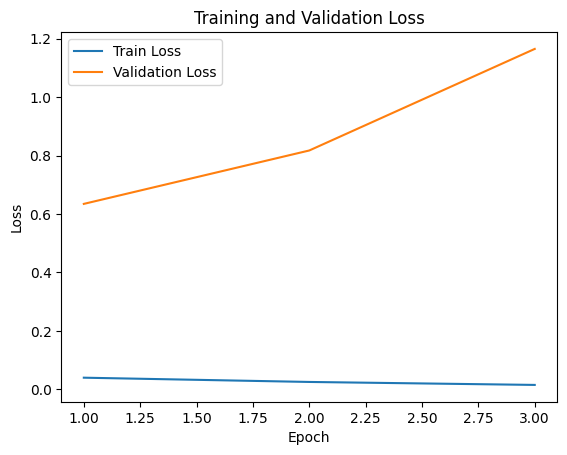

In [ ]:
plot_loss_curve(avr_train_loss, avr_test_loss)

# retrive MLP and BiLSTM models

In [ ]:
BiLSTM_cwi = torch.load('/content/drive/MyDrive/bilstm_1.pth', map_location=torch.device('cpu'))
MLP_cwi = torch.load('/content/drive/MyDrive/modified_MLP_cwi.pth', map_location=torch.device('cpu'))


# Simplification:
**Sub. Generation (SG)**
1. mask predicted complex word
2. concatenate masked sentence with original sentence + adding SEP and CLS tokens for roberta maske language model
**Sub. Ranking**
  3. remove suggestions with zipf value below 3
  4. apply 4 critics for SR:
    1. calculate zipf for each suggestions
    2. rank base on Mask Model prediction order
    3. calculate loss for each sequence containing target word
    4. calculate cosine similarity base on FastText model
    5. avrageing all rankings.
    
**Sub. Selection**
5. choose the highest as the better suggestion and replace it with target word

In [ ]:
!pip install wordfreq


In [ ]:
from transformers import AutoTokenizer, RobertaForMaskedLM
import torch
import copy
from wordfreq import zipf_frequency
from statistics import mean
from transformers import AutoTokenizer, AutoModelForMaskedLM

import json





In [ ]:
with open('/content/drive/MyDrive/LSBERT_resources/word2index.json', 'r') as json_file:
    new_word2index = json.load(json_file)

In [ ]:
from transformers import pipeline
"""
this module aim to get word_label_dict (CWI phase) for finetuned CWI base on bert, the model is in classifier variable

"""
# classifier = pipeline("token-classification", model="zahrainnlp/bert_base_cwi")

def get_word_label_dict(context, cwi_classifier):

  # preprocessing:

  hazm_normalizer = Normalizer()
  hazm_w_tokenizer = WordTokenizer()
  context = hazm_normalizer.normalize(context)
  context = hazm_normalizer.correct_spacing(context)

  result = cwi_classifier(context)
  keys = []
  values = []

  for i in range(len(context.split())):
    if result[i]['entity'] == 'non_complex' :
      values.append(0)
    else:
      values.append(1)

    keys.append(result[i]['word'])


  result_dict = {word: value for word, value in zip(keys, values)}

  return result_dict


In [ ]:
"""
this module is for cwi models base on SVM and BRF. this module aim to get word label dictionary (cwi phase) from this models specificly
"""

normalizer = Normalizer()
tokenizer = WordTokenizer()

def get_word_label_dict(context, cwi_model, llm_model=R_model, llm_tokenizer=R_tokenizer):

  # normalize
  context = normalizer.normalize(context)
  context = normalizer.correct_spacing(context)
  # tokenize
  tokens = tokenizer.tokenize(context)


  tokenized_inputs = llm_tokenizer(tokens, is_split_into_words=True, add_special_tokens=True, return_tensors='pt').to(device)

  llm_model.eval()

  with torch.no_grad():
      hidden_states = llm_model(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'], output_hidden_states=True)['hidden_states']

  token_embeddings = torch.stack(hidden_states[-4:], dim=0).squeeze(1).permute(1, 0, 2)
  token_vecs_sum = torch.stack([torch.sum(token[-4:], dim=0) for token in token_embeddings])


  # cwi Model Inference

  input_embeddings = token_vecs_sum

  predictions = cwi_model.predict(input_embeddings.cpu())



  # turn binary tensor more readble:

  tokenized_inputs_without_padding = llm_tokenizer(tokens, is_split_into_words=True, add_special_tokens=True,)
  end_idx = (len(tokenized_inputs_without_padding['input_ids']) - 1 )
  R_labels_list = predictions.tolist()[1:end_idx]
  w_ids = tokenized_inputs_without_padding.word_ids()[1:end_idx]

  d = {}
  for l, id in zip(R_labels_list, w_ids):
    # print(l)
    # print(id)
    value = tokens[id]
    if value in d:
      d[value].append(int(l))
    else:
      d[value] = [int(l)]

  for k, v in d.items():
    if len(v) > 1 and 1 in v:
      d[k] = [1]
    elif len(v) > 1 and 1 not in v:
      d[k] = [0]

  return d

In [ ]:
"""this module is for LSBERT_cwi, base on glove and BiLSTm
"""
class BiLSTM(nn.Module):
    def __init__(self, weights, hidden_size, num_layers, num_classes, dropout):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)


        self.embedding = nn.Embedding.from_pretrained(weights, padding_idx= 0, freeze=True)
        self.lstm = nn.LSTM(weights.size(1), hidden_size, num_layers, batch_first=True,
                            bidirectional=True, dropout = dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, num_classes)


    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)

        logits = self.dropout(self.fc(self.dropout(lstm_out)))

        # out = self.fc(lstm_out)
        return logits
# this module is for LSBERT_cwi, base on glove and BiLSTm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
LSBERT_cwi = torch.load('/content/drive/MyDrive/LSBERT_resources/cwi_LSBERT_1.pth', map_location=device) #LSBERT, cwi base on glove embeddings and BiLSTM
# zahra_CWI = torch.load('/content/drive/MyDrive/thesis_resources/bilstm_1.pth', map_location=device) #LSBERT, cwi base on bert embeddings, whole sentence, BiLSTM

In [ ]:
"""for LSBERT, cwi base on glove embeddings and BiLSTM"""

def get_word_label_dict_LSBERT(context, cwi_model, word2index):
  """
  # for LSBERT, cwi base on glove embeddings and BiLSTM
  """
  # preprocessing:

  hazm_normalizer = Normalizer()
  hazm_w_tokenizer = WordTokenizer()
  context = hazm_normalizer.normalize(context)
  context = hazm_normalizer.correct_spacing(context)
  all_words = hazm_w_tokenizer.tokenize(context)

  numericalized_tokens = [word2index[word] if word in word2index else word2index['-OOV-'] for word in all_words]

  token_tensor = torch.LongTensor(numericalized_tokens)

  token_tensor = token_tensor.unsqueeze(-1)  #add batch number dimention
  token_tensor = token_tensor.to(device)
  # get prediction

  predictions = cwi_model(token_tensor)

  top_predictions = predictions.argmax(-1)

  # turn binary tensor more readble:

  result = top_predictions.tolist()

  result_dict = {word: value for word, value in zip(all_words, result)}

  return result_dict


In [ ]:
"""for LSBERT, cwi base on glove embeddings and BiLSTM"""

def get_word_label_dict_LSBERT(context, cwi_model, word2index):
  """
  # for LSBERT, cwi base on glove embeddings and BiLSTM
  """
  # preprocessing:

  hazm_normalizer = Normalizer()
  hazm_w_tokenizer = WordTokenizer()
  context = hazm_normalizer.normalize(context)
  context = hazm_normalizer.correct_spacing(context)
  all_words = hazm_w_tokenizer.tokenize(context)

  numericalized_tokens = [word2index[word] if word in word2index else word2index['-OOV-'] for word in all_words]

  token_tensor = torch.LongTensor(numericalized_tokens)

  token_tensor = token_tensor.unsqueeze(-1)  #add batch number dimention
  token_tensor = token_tensor.to(device)
  # get prediction

  predictions = cwi_model(token_tensor)

  top_predictions = predictions.argmax(-1)

  # turn binary tensor more readble:

  result = top_predictions.tolist()

  result_dict = {word: value for word, value in zip(all_words, result)}

  return result_dict


In [ ]:
"""this module is for zahra_CWI, base on bert embeddings and BiLSTm
"""
class BiLSTMTagger(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout,
                        ):

        super(BiLSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0,
                            batch_first =True,)

        # self.batch_norm = nn.BatchNorm1d(2 * hidden_dim)

        # self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def forward(self, embedded_text):

        outputs, _ = self.lstm(embedded_text)

        # outputs = self.batch_norm(outputs.permute(0, 2, 1))

        # logits = self.dropout(self.fc(self.dropout(outputs.permute(0, 2, 1))))
        logits = self.dropout(self.fc(self.dropout(outputs)))

        return logits

In [ ]:
llm_model = AutoModelForTokenClassification.from_pretrained('HooshvareLab/bert-base-parsbert-armanner-uncased')
llm_tokenizer =  AutoTokenizer.from_pretrained('HooshvareLab/bert-base-parsbert-armanner-uncased')

In [ ]:
llm_model = llm_model.to(device)

In [ ]:
"""# for cwi base on bert embeddings
"""
normalizer = Normalizer()
tokenizer = WordTokenizer()

def get_word_label_dict(context, cwi_model, llm_model, llm_tokenizer):
  """
    # for cwi base on bert embeddings

  """
  # preprocessing:

  # normalize
  context = normalizer.normalize(context)
  context = normalizer.correct_spacing(context)
  # tokenize
  tokens = tokenizer.tokenize(context)
  # extract LLM embeddings for each token
  # getting input ids and attention mask and embedding
  tokenized_inputs = llm_tokenizer(tokens, is_split_into_words=True, add_special_tokens=True, return_tensors='pt', padding= 'max_length', max_length=219,)
  tokenized_inputs = tokenized_inputs.to(device)

  llm_model.eval()

  with torch.no_grad():
      hidden_states = llm_model(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'], output_hidden_states=True)['hidden_states']

  token_embeddings = torch.stack(hidden_states[-4:], dim=0).squeeze(1).permute(1, 0, 2)
  token_vecs_sum = torch.stack([torch.sum(token[-4:], dim=0) for token in token_embeddings])


  # starting model to predict labels:

  # cwi Model Inference
  cwi_model.eval()
  with torch.no_grad():
      # # Reshape the input to match the expected size
      input_embeddings = token_vecs_sum

      logits = cwi_model(input_embeddings)

      predictions = torch.argmax(logits, dim=1)

  # Post-processing (example: thresholding at 0.5)
  binary_predictions = (predictions >= 0.5).int()


  # turn binary tensor more readble:

  tokenized_inputs_without_padding = llm_tokenizer(tokens, is_split_into_words=True, add_special_tokens=True,)

  end_idx = (len(tokenized_inputs_without_padding['input_ids']) - 1 )

  R_labels_list = binary_predictions.squeeze(0).tolist()[1:end_idx]
  w_ids = tokenized_inputs_without_padding.word_ids()[1:end_idx]

  d = {}
  for l, id in zip(R_labels_list, w_ids):
    value = tokens[id]
    if value in d:
      d[value].append(int(l))
    else:
      d[value] = [int(l)]

  for k, v in d.items():
    if len(v) > 1 and 1 in v:
      d[k] = [1]
    elif len(v) > 1 and 1 not in v:
      d[k] = [0]

  return d

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

mask_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
mask_model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base").to(device)

In [ ]:
mask_model.config.vocab_size = mask_tokenizer.vocab_size
hazm_normalizer = Normalizer()


def get_suggestions(context, word_label_dict, mask_tokenizer, mask_model, predictions_number):
  word_subs_dic = {}
  context = hazm_normalizer.normalize(context)
  for v, k in word_label_dict.items():
      # print(v, k)
      if 1 in k:
        target = v
        masked_sent = context.replace(target, '<mask>')

        mask_token = ' <mask>'
        if mask_token in masked_sent:
          masked_text = f'<s> {masked_sent} </s></s> {context} </s> '

          encoded_input = mask_tokenizer(masked_text, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
          output = mask_model(**encoded_input)
          mask_token = ' <mask>'

          mask_index = mask_tokenizer.tokenize(masked_text, padding=True, truncation=True, max_length=512,).index(mask_token) + 1

          predictions = output[0][0][mask_index]
          predicted_ids = torch.argsort(predictions, descending=True)[:predictions_number]
          predicted_tokens = mask_tokenizer.convert_ids_to_tokens(list(predicted_ids))

          word_subs_dic[v] = predicted_tokens

        else:
          word_subs_dic[v] = []

      else:
        word_subs_dic[v] = []

  return word_subs_dic


In [ ]:
#  step A: remove suggestion with zipf value less than 3


def SR_stepA(word_suggestions_dict):
    stop_words = stopwords_list()  # Assuming stopwords_list() is defined somewhere!

    new_word_sug_dict = {}

    for word, sug_list in word_suggestions_dict.items():
        new_sug_list = []

        if len(sug_list) != 0:
            for suggestion in sug_list:
                suggestion = re.sub('▁', '', suggestion)
                if suggestion not in stop_words:
                    suggestion_value = zipf_frequency(suggestion, 'fa')  # Assuming zipf_frequency is defined somewhere
                    if suggestion_value > 3:
                        new_sug_list.append(suggestion)

        new_word_sug_dict[word] = new_sug_list if len(new_sug_list) != 0 else []

    return new_word_sug_dict




In [ ]:
def SR_bert_score(modified_word_sug_dict):
    word_order_score = {}
    for word, sug_list in modified_word_sug_dict.items():
        order_score = list(range(len(sug_list), 0, -1)) if sug_list else []
        word_order_score[word] = list(zip(sug_list, order_score))

    return word_order_score

In [ ]:
import gc
import fasttext
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="facebook/fasttext-fa-vectors", filename="model.bin")
FastText_model = fasttext.load_model(model_path)

def cosine_similarity(word1, word2, model):

    return np.dot(model[word1], model[word2]) / (np.linalg.norm(model[word1]) * np.linalg.norm(model[word2]))

def SR_similarity_score (modified_word_sug_dict):

  word_similarity_score = {}
  for word, sug_list in  modified_word_sug_dict.items():
    if len(sug_list) != 0 :
      sug_list_score = []
      for suggestion in sug_list:
        cosine_similarity_score = cosine_similarity(word, suggestion, FastText_model)
        sug_list_score.append(round(cosine_similarity_score, 2))

      word_similarity_score[word] = list(zip(sug_list, sug_list_score))

    else:
      word_similarity_score[word] = []


  # del FastText_model
  gc.collect()
  return word_similarity_score

In [ ]:
from transformers import AutoTokenizer, RobertaForMaskedLM
import torch
import copy

# worked:
def get_MLM_loss(mask_model, mask_tokenizer, masked_sent, sent):
    # Tokenize sentences
    inputs = mask_tokenizer(masked_sent, sent, return_tensors="pt", padding=True, truncation=True).to(device)

    labels = inputs.input_ids.clone()  # Clone the input_ids tensor
    # Mask labels of non-<mask> tokens
    labels[labels != mask_tokenizer.mask_token_id] = -100
    outputs = mask_model(**inputs, labels=labels)

    return round(outputs.loss.item(), 2)

def get_surrounding_indices(index, length):
  left_index = index - 5 if index > 4 else 0
  right_index = index + 5 if length - 1 - index > 4 else length - 1
  if index - left_index < 5:
    right_index += 5 - (index - left_index)
  if right_index - index < 5:
    left_index -= 5 - (right_index - index)
  return (left_index, right_index + 1)

def SR_loss_score(modified_word_sug_dict, mask_model, mask_tokenizer):

  word_loss_score = {}
  for word, sug_list in  modified_word_sug_dict.items():
    if len(sug_list) != 0 :
      sug_list_score = []

      for suggestion in sug_list:
        original_sent = ' '.join(list(modified_word_sug_dict.keys()))

        W = re.sub(word, suggestion, original_sent)
        W_list = W.split()
        W_loss_scores = []
        target_token_index = W_list.index(suggestion)
        W_length = len(W_list)
        if W_length > 10:
          (minus_fifth_index, plus_fifth_index) = get_surrounding_indices(target_token_index, W_length)
          W = W[minus_fifth_index : plus_fifth_index]

        for i in range(W_length):
          masked_token = W_list[i]
          masked_sent = W.replace(masked_token, '<mask>')
          loss_score = get_MLM_loss(mask_model, mask_tokenizer, masked_sent, W)
          W_loss_scores.append(loss_score)

        suggestion_score = mean(W_loss_scores)
        sug_list_score.append(round(suggestion_score, 2))

      word_loss_score[word] = list(zip(sug_list, sug_list_score))

    else:
      word_loss_score[word] = []

  return word_loss_score

In [ ]:
def SR_zipf_score (modified_word_sug_dict):
  word_zipf_score = {}
  for word, sug_list in  modified_word_sug_dict.items():
    if len(sug_list) != 0 :
      zipf_value = []
      for suggestion in sug_list:
        zipf_value.append(zipf_frequency(suggestion, 'fa'))

      ranked_list = [sorted(zipf_value).index(x) + 1 for x in zipf_value]

      word_zipf_score[word] = list(zip(sug_list, ranked_list))

    else:
      word_zipf_score[word] = []

  return word_zipf_score



In [ ]:
def get_ranking(input_dict):
  result = {}
  for word, subs_list in input_dict.items():
    if len(subs_list) != 0:
      sorted_subs_list = sorted(subs_list, key=lambda x: x[1], reverse=True)
      n = len(subs_list)
      ranked_subs_list = [(t[0], n - i) for i, t in enumerate(sorted_subs_list)]

      result[word] = ranked_subs_list
    else:
      result[word] = []

  return result


def get_loss_ranking(loss_score_dict):
  result = {}
  for word, subs_list in loss_score_dict.items():
    if len(subs_list) != 0:
      sorted_subs_list = sorted(subs_list, key=lambda x: (x[1], subs_list.index(x)))
      n = len(subs_list)
      ranked_subs_list = [(t[0], n - i) for i, t in enumerate(sorted_subs_list)]

      result[word] = ranked_subs_list
    else:
      result[word] = []

  return result

In [ ]:

def get_tuple_by_name(arr, name):
  for tup in arr:
    if tup[0] == name:
      return tup

def merge_values(temp_list, value):
  arr = []
  for tup in value:
    temp_tup = get_tuple_by_name(temp_list, tup[0])
    arr.append((tup[0], (tup[1] + temp_tup[1])/ 2))
  return arr

def round_tuples(temp):
  final_result = {}
  for var in temp:
    final_result[var] = []
    if len(temp[var]) > 0:
      for tup in temp[var]:
        value = (tup[0], round(tup[1], 2))
        final_result[var].append(value)
  return final_result

def get_final_score(*args):
  temp = {}
  for dic in args:
    for var in dic:
      temp_list = temp.get(var, [])
      current_list = dic[var]
      if len(current_list) > 0 and len(temp_list) > 0:
        current_list = merge_values(temp_list, current_list)
      temp[var] = current_list
  temp = round_tuples(temp)

  return temp


def get_highest_score(arr, word):
  highest = 0
  highest_tup = None
  for tup in arr:
    if tup[1] > highest and tup[0] != word:
      highest = tup[1]
      highest_tup = tup
  return highest_tup

def get_highest_score_in_dic(dic):
  temp = {}
  for var in dic:
    x = get_highest_score(dic[var], var)
    temp[var] = x
  return temp

def get_final_string(dic):
  x = get_highest_score_in_dic(dic)
  sentence = ''
  for var in x:
    sentence += ' '
    if x[var] != None:
      sentence +=  x[var][0]
    else:
      sentence += var
  return sentence

In [ ]:
import time
# for cwi base on glove embeddings
def simplification_alg_LSBERT(row, mask_tokenizer=mask_tokenizer, mask_model=mask_model, cwi_model=LSBERT_cwi, suggestions_count=10, stop_words = stopwords_list(), word2index=new_word2index):
  first_start = time.time()
  print(row.name)
  text = row['sentence']
  # text = context

  """ step1: prepare word_label_dict word as key and binary label as value (CWI)"""
  cwi_dict = get_word_label_dict_LSBERT(text, cwi_model, word2index)
  # print(cwi_dict)
  """ step2: prepare suggestions as a dictionary. key: word value: list of suggestions (SG)"""
  # first_start = time.time()
  word_suggestions_dict = get_suggestions(text, cwi_dict, mask_tokenizer, mask_model, suggestions_count)
  # print(word_suggestions_dict)

  """ step3: Substitudes Ranking"""
  """  step A: remove suggestion with zipf value less than 3 """

  modified_word_suggestion_dict = SR_stepA(word_suggestions_dict)
  # print(modified_word_suggestion_dict)
  """  step B: calculate 4 criteria to score each substitude for each complex word """
  """  B-1: BERT prediction order criteria """

  # BERT_score_dict = SR_bert_score(modified_word_suggestion_dict)
  # # print(BERT_score_dict)
  """  B-2: mask model loss criteria """

  loss_score_dict = SR_loss_score(modified_word_suggestion_dict, mask_model, mask_tokenizer)
  loss_score_dict = get_loss_ranking(loss_score_dict)
  # print(loss_score_dict)
  """  B-3: cosine similarity between target word and sub word criteria """

  # similarity_score_dict = SR_similarity_score(modified_word_suggestion_dict)
  # similarity_score_dict = get_ranking(similarity_score_dict)
  # print(similarity_score_dict)
  """  B-4: zipf value criteria """

  # zipf_score_dict = SR_zipf_score(modified_word_suggestion_dict)
  # # print(zipf_score_dict)
  """  step C: calculate all criterias for each """

  final_score = get_final_score(loss_score_dict)#loss_score_dict, similarity_score_dict, zipf_score_dict, BERT_score_dict,
  # print(final_score)
  """  SS, select best and return string """

  final_string = get_final_string(final_score)
  # first_end = time.time()
  # print(first_end - first_start)
  return final_string

In [ ]:
# # # for cwi base on bert embeddings

import time

def simplification_alg(row, mask_tokenizer=mask_tokenizer, mask_model=mask_model, cwi_model=zahra_CWI, llm_model=llm_model, llm_tokenizer=llm_tokenizer, suggestions_count=10, stop_words = stopwords_list(),):
  # ll_model and llm_tokenizer are bert models thatwere initialy used to make cwi base on bert embeddings
  # first_start = time.time()
  print(row.name)
  text = row['sentence']

  """ step1: prepare word_label_dict word as key and binary label as value (CWI)"""
  cwi_dict = get_word_label_dict(text, cwi_model, llm_model, llm_tokenizer)

  """ step2: prepare suggestions as a dictionary. key: word value: list of suggestions (SG)"""
  # first_start = time.time()
  word_suggestions_dict = get_suggestions(text, cwi_dict, mask_tokenizer, mask_model, suggestions_count)


  """ step3: Substitudes Ranking"""
  """  step A: remove suggestion with zipf value less than 3 """

  modified_word_suggestion_dict = SR_stepA(word_suggestions_dict)

  """  step B: calculate 4 criteria to score each substitude for each complex word """
  """  B-1: BERT prediction order criteria """

  # BERT_score_dict = SR_bert_score(modified_word_suggestion_dict)

  """  B-2: mask model loss criteria """

  loss_score_dict = SR_loss_score(modified_word_suggestion_dict, mask_model, mask_tokenizer)
  loss_score_dict = get_loss_ranking(loss_score_dict)

  """  B-3: cosine similarity between target word and sub word criteria """

  # similarity_score_dict = SR_similarity_score(modified_word_suggestion_dict)
  # similarity_score_dict = get_ranking(similarity_score_dict)
  """  B-4: zipf value criteria """

  # zipf_score_dict = SR_zipf_score(modified_word_suggestion_dict)

  """  step C: calculate all criterias for each """

  final_score = get_final_score(loss_score_dict)#loss_score_dict, similarity_score_dict, zipf_score_dict, BERT_score_dict,

  """  SS, select best and return string """

  final_string = get_final_string(final_score)
  # first_end = time.time()
  # print(first_end - first_start)
  return final_string


In [ ]:
samples_df = pd.read_csv('/content/drive/MyDrive/LSBERT_resources/evaluation_samples_500_modified.csv')

In [ ]:
samples_df['model_simplified'] = samples_df.apply(simplification_alg_LSBERT,
                                                   axis=1)

# calculate SARI and BLEU to evaluate simplification process for each model output base on 492 extractes phrases for this evaluation purpose

In [ ]:
eval_df = pd.read_csv('/content/drive/MyDrive/simplification_evaluation_resources/simplified_samples_4_Eval_492.csv')
eval_df


,target,original_sentence,ref_1,ref_2,LSBERT_simpl,ziph_simpl,similarity_simpl,BERT_simpl,loss_simpl,z_LSBERT_all,z_LSBERT_zipf,z_LSBERT_sim,z_LSBERT_bert,z_LSBERT_loss
0,ضدکشتی,مدل‌ها نسخه‌های مخصوص ارتش روسیه: ۳ ام ۵۴: نس...,مدل‌ها نمونه‌های مخصوص ارتش روسیه: ۳ ام ۵۴: ن...,مدل‌ها نسخه‌های مخصوص ارتش روسیه: ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: سر...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...,مدل‌ها نسخه‌های مخصوص ارتش روسیه : ۳ ام ۵۴: نس...
1,دشتبان,به گزارش صبحانه، متهم ۳۸ ساله این پرونده که در...,به گزارش صبحانه، متهم ۳۸ ساله این پرونده که در...,به گزارش صبحانه، متهم ۳۸ ساله این پرونده که در...,به گزارش صبحانه ، متهم ۳۸ ساله این پرونده که د...,به همراه صبحانه ، مرد ۸ سال این پرونده که در پ...,به خبرگزاری صبحانه ، محکوم ۲۲ ماهه این پرونده ...,به خبرنگار صبحانه ، فعال 38 سال این پرونده که ...,به گزارش صبحانه ، متهم ۳۸ ساله این پرونده که د...,به گزارش صبحانه ، متهم ۳۸ ساله این پرونده که د...,به گزارش صبحانه ، متهم ۳۸ ساله این پرونده که د...,به گزارش صبحانه ، متهم ۳۸ ساله این پرونده که د...,به گزارش صبحانه ، متهم ۳۸ ساله این پرونده که د...,به گزارش صبحانه ، متهم ۳۸ ساله این پرونده که د...
2,باز‌کردن,اگر مجددا اقدام به باز‌کردن نرم‌افزار اشاره‌شد...,اگر دوباره اقدام به باز‌کردن نرم‌افزار اشاره‌ش...,اگر دوباره اقدام به باز‌کردن برنامه اشاره‌شده ...,اگر مجددا اقدام به باز‌کردن نرم‌افزار اشاره‌شد...,اگر مجددا دست به باز‌کردن نرم‌افزار اشاره بکنی...,اگر مجددا عمل به باز‌کردن نرم‌افزار اشاره بکنی...,اگر مجددا تصمیم به باز‌کردن نرم‌افزار اشاره بک...,اگر مجددا اقدام به باز‌کردن نرم‌افزار اشاره‌شد...,اگر مجددا اقدام به باز‌کردن نرم‌افزار اشاره‌شد...,اگر مجددا اقدام به باز‌کردن نرم‌افزار اشاره‌شد...,اگر مجددا اقدام به باز‌کردن نرم‌افزار اشاره‌شد...,اگر مجددا اقدام به باز‌کردن نرم‌افزار اشاره‌شد...,اگر مجددا اقدام به باز‌کردن نرم‌افزار اشاره‌شد...
3,استفسار,وقتی محاذی ایستگاه اتومبیل‌های حاج در این بیاب...,وقتی روبه‌رو ایستگاه اتومبیل‌های حاج در این بی...,وقتی روبروی ایستگاه اتومبیل‌های حاج در این بیا...,وقتی محاذی ایستگاه اتومبیل‌های حاج در این بیاب...,وقتی محاذی ایستگاه اتومبیل‌های آقا در این بیاب...,وقتی محاذی ایستگاه اتومبیل‌های آقا در این بیاب...,وقتی محاذی ایستگاه اتومبیل‌های حج در این بیابا...,وقتی محاذی ایستگاه اتومبیل‌های حاج در این بیاب...,وقتی محاذی ایستگاه اتومبیل‌های حاج در این بیاب...,وقتی محاذی ایستگاه اتومبیل‌های حاج در این بیاب...,وقتی محاذی ایستگاه اتومبیل‌های حاج در این بیاب...,وقتی محاذی ایستگاه اتومبیل‌های حاج در این بیاب...,وقتی محاذی ایستگاه اتومبیل‌های حاج در این بیاب...
4,عمومی‌شان,هابرماس معتقد است، عرصه عمومی زمانی پدید می‌آی...,هابرماس معتقد است، مکان عمومی زمانی به وجود می...,هابرماس معتقد است، عرصه عمومی زمانی بوجود می‌آ...,هابرماس معتقد است ، عرصه عمومی زمانی پدید می‌آ...,هابرماس معتقد است ، بازار عمومی زمانی پدید می‌...,هابرماس معتقد است ، حوزه عمومی زمانی پدید می‌آ...,هابرماس معتقد است ، فضای عمومی زمانی پدید می‌آ...,هابرماس معتقد است ، عرصه عمومی زمانی پدید می‌آ...,هابرماس معتقد است ، عرصه عمومی زمانی پدید می‌آ...,هابرماس معتقد است ، عرصه عمومی زمانی پدید می‌آ...,هابرماس معتقد است ، عرصه عمومی زمانی پدید می‌آ...,هابرماس معتقد است ، عرصه عمومی زمانی پدید می‌آ...,هابرماس معتقد است ، عرصه عمومی زمانی پدید می‌آ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,سالیانه,براین اساس اگر هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس اگر هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس اگر هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس اگر هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس اگه هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس اگه هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس اگه هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس اگر هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس اگر هفته‌ای ۱۰ درصد ارزش افزوده تول...,براین اساس 

In [ ]:
# hazm_normalizer = Normalizer()

hazm_w_tokenizer = WordTokenizer()

In [ ]:

original_sents = eval_df['original_sentence']
ref1 = eval_df['ref_1']
ref2 = eval_df['ref_2']

LSBERT = eval_df['z_LSBERT_all']
ziph = eval_df['z_LSBERT_zipf']
bert = eval_df['z_LSBERT_bert']
similarity = eval_df['z_LSBERT_sim']
loss = eval_df['z_LSBERT_loss']

**BLEU**

In [ ]:
import evaluate
bleu = evaluate.load("bleu")

In [ ]:
sources = original_sents.tolist()

total_pred = LSBERT.tolist()
ziph_pred = ziph.tolist()
similarity_prd = similarity.tolist()
bert_predi = bert.tolist()
loss_pred = loss.tolist()


references_1 = [[ref] for ref in ref1.tolist()]
references_2 = [[ref] for ref in ref2.tolist()]

both_refrences = [[ref_1, ref_2] for ref_1, ref_2 in zip(ref1.tolist(), ref2.tolist())]

In [ ]:


bleu_only_Ref1 = bleu.compute(predictions=similarity_prd, references=references_1, tokenizer=hazm_w_tokenizer.tokenize)
bleu_only_Ref2 = bleu.compute(predictions=similarity_prd, references=references_2, tokenizer=hazm_w_tokenizer.tokenize)
bleu_both_refs = bleu.compute(predictions=similarity_prd, references=both_refrences, tokenizer=hazm_w_tokenizer.tokenize)


In [ ]:
print('bleu_only_Ref1: ', bleu_only_Ref1, '\n','bleu_only_Ref2: ' ,bleu_only_Ref2, '\n', 'bleu_both_refs: ',bleu_both_refs)

bleu_only_Ref1:  {'bleu': 0.5813672763634791, 'precisions': [0.9652068126520681, 0.7880117875728886, 0.6528011385690258, 0.5481392396605866], 'brevity_penalty': 0.8049045096356285, 'length_ratio': 0.821671331467413, 'translation_length': 16440, 'reference_length': 20008} 
 bleu_only_Ref2:  {'bleu': 0.5707704391140918, 'precisions': [0.9566301703163017, 0.7749702175684996, 0.6367576659334973, 0.530700875258903], 'brevity_penalty': 0.8067671463649692, 'length_ratio': 0.8232348522784176, 'translation_length': 16440, 'reference_length': 19970} 
 bleu_both_refs:  {'bleu': 0.6092582503630647, 'precisions': [0.9842457420924574, 0.8167283215248605, 0.686764135075689, 0.5841518006280484], 'brevity_penalty': 0.8084865459354519, 'length_ratio': 0.8246802106847254, 'translation_length': 16440, 'reference_length': 19935}


**sari**

In [ ]:
!pip install sacremoses sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 11.0 MB/s eta 0:00:00


In [ ]:
from evaluate import load
sari = load("sari")


In [ ]:
sari_only_Ref1 = sari.compute(sources=sources, predictions=total_pred, references=references_1)
sari_only_Ref2 = sari.compute(sources=sources, predictions=total_pred, references=references_2)


In [ ]:
sari_total = sari.compute(sources=sources, predictions=total_pred, references=both_refrences)


In [ ]:
print('sari_only_Ref1: ', sari_only_Ref1, '\n', 'sari_only_Ref2: ',sari_only_Ref2, '\n', 'sari_total', sari_total)

sari_only_Ref1:  {'sari': 35.782177352294845} 
 sari_only_Ref2:  {'sari': 35.48318124698324} 
 sari_total {'sari': 34.93180092486218}
